## Telecom churn case study

### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively
switch from one operator to another. In this highly competitive market, the telecommunications industry
experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to
acquire a new customer than to retain an existing one, customer retention has now become even more
important than customer acquisition.

#### Predict which customers are at high risk of churn

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)


from pandas import Series as s , DataFrame as df
import numpy as np
import seaborn as sns

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt, rcParams as rc

%matplotlib inline
rc["figure.figsize"] = 10,6


from sklearn.model_selection  import StratifiedKFold
from sklearn.decomposition import PCA

from iteration_utilities import duplicates, unique_everseen

from sklearn.base import TransformerMixin, BaseEstimator

from collections import Counter , defaultdict

In [160]:
#preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, normalize

#Modle Selection
from sklearn.model_selection import train_test_split

#Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
import lightgbm as lgb

#Evaluation Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, explained_variance_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_recall_fscore_support

from sklearn.pipeline import Pipeline

# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import time
s1time = time.clock()
# # Importing libraries


from sklearn.model_selection  import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import auc,hinge_loss,log_loss,precision_recall_fscore_support,roc_auc_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [3]:

## RandomOverSampler to handle imbalanced data
from imblearn.over_sampling import RandomOverSampler # over sampling method 2


from pandas.api.types import is_numeric_dtype

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
import statsmodels.api as sm 

Using TensorFlow backend.


In [4]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 2000
pd.options.display.float_format = '{:.2f}'.format

In [5]:
# Load Data Set
telecom_df =  pd.read_csv('telecom_churn_data.csv',encoding='palmos', engine='python')
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,5.44,0.00,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,na

In [6]:
telecom_df.shape

(99999, 226)

In [7]:
def get_percentage_miss_value(dataset):
    higher_miss_value_column = []
    miss_threshold_value = 50
    
    for i in dataset.columns:
        if dataset[i].isna().sum() > 1: 
            perectange_val = (dataset[i].isna().sum() / len(dataset)) * 100
            print("Column-> " , i, ", total no of missing value : ",dataset[i].isna().sum() , " & :         ", round(perectange_val,2) ," %")
                
            if(perectange_val > miss_threshold_value):
                higher_miss_value_column.append(i)
            
    print("\n\n\n")
        
    if higher_miss_value_column:
        print("Higher Missing values in Columns for Delete : \n\n", higher_miss_value_column) 
        
        return higher_miss_value_column
    else:
        print("There are no Higher Column Missing values in Dataset")

In [8]:
 # Also lets check how many columns have more than 50% data missing

get_percentage_miss_value(telecom_df)
# Lets check the percentage of missing values column-wise


Column->  loc_og_t2o_mou , total no of missing value :  1018  & :          1.02  %
Column->  std_og_t2o_mou , total no of missing value :  1018  & :          1.02  %
Column->  loc_ic_t2o_mou , total no of missing value :  1018  & :          1.02  %
Column->  last_date_of_month_7 , total no of missing value :  601  & :          0.6  %
Column->  last_date_of_month_8 , total no of missing value :  1100  & :          1.1  %
Column->  last_date_of_month_9 , total no of missing value :  1659  & :          1.66  %
Column->  onnet_mou_6 , total no of missing value :  3937  & :          3.94  %
Column->  onnet_mou_7 , total no of missing value :  3859  & :          3.86  %
Column->  onnet_mou_8 , total no of missing value :  5378  & :          5.38  %
Column->  onnet_mou_9 , total no of missing value :  7745  & :          7.75  %
Column->  offnet_mou_6 , total no of missing value :  3937  & :          3.94  %
Column->  offnet_mou_7 , total no of missing value :  3859  & :          3.86  %
Colum

Column->  ic_others_7 , total no of missing value :  3859  & :          3.86  %
Column->  ic_others_8 , total no of missing value :  5378  & :          5.38  %
Column->  ic_others_9 , total no of missing value :  7745  & :          7.75  %
Column->  date_of_last_rech_6 , total no of missing value :  1607  & :          1.61  %
Column->  date_of_last_rech_7 , total no of missing value :  1767  & :          1.77  %
Column->  date_of_last_rech_8 , total no of missing value :  3622  & :          3.62  %
Column->  date_of_last_rech_9 , total no of missing value :  4760  & :          4.76  %
Column->  date_of_last_rech_data_6 , total no of missing value :  74846  & :          74.85  %
Column->  date_of_last_rech_data_7 , total no of missing value :  74428  & :          74.43  %
Column->  date_of_last_rech_data_8 , total no of missing value :  73660  & :          73.66  %
Column->  date_of_last_rech_data_9 , total no of missing value :  74077  & :          74.08  %
Column->  total_rech_data_6 

['date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'total_rech_data_9',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'max_rech_data_9',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_2g_9',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'count_rech_3g_9',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'av_rech_amt_data_9',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_3g_9',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_2g_9',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'night_pck_user_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9']

We see that there are a few columns which have more than 70% of data missing. We will drop the columns as they would convey a very little information.

We have to define high-value customers as - Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

So we do not drop the columns related to the recharge amounts. Thus to avoid doing that first we will flush the missing values in these columns -

• total_rech_data_6 - 74.8467 % missing values

• total_rech_data_7 - 74.4287 % missing values

• av_rech_amt_data_6 - 74.8467 % missing values

• av_rech_amt_data_7 - 74.4287 % missing values


We have 2 more columns as -

•date_of_last_rech_data_6 - 74.8467 % missing values

•date_of_last_rech_data_7 - 74.4287 % missing values


## Filter High Value Customers

Filtering High Value Customers as they are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [9]:
# calculate the total data recharge amount for June and July --> number of recharges * average recharge amount
telecom_df['total_data_rech_6'] = telecom_df['total_rech_data_6'] * telecom_df['av_rech_amt_data_6']
telecom_df['total_data_rech_7'] = telecom_df['total_rech_data_7'] * telecom_df['av_rech_amt_data_7']

telecom_df['amt_data_6'] = telecom_df[['total_rech_amt_6','total_data_rech_6']].sum(axis=1)
telecom_df['amt_data_7'] = telecom_df[['total_rech_amt_7','total_data_rech_7']].sum(axis=1)

telecom_df['AVG_amt_data_6_7'] = telecom_df[['amt_data_6','amt_data_7']].mean(axis=1)

In [10]:
telecom_df[['total_rech_amt_6','total_rech_amt_7','AVG_amt_data_6_7']].quantile([0.25,0.5,0.7,0.75,0.9])

,total_rech_amt_6,total_rech_amt_7,AVG_amt_data_6_7
0.25,109.00,100.00,128.00
0.50,230.00,220.00,275.00
0.70,378.00,370.00,478.00
0.75,437.50,428.00,553.00
0.90,732.00,731.00,1028.00


In [11]:
telecom_df = telecom_df[(telecom_df['AVG_amt_data_6_7']> telecom_df['AVG_amt_data_6_7'].quantile(0.7))]
telecom_df.shape

(29953, 231)

In [12]:
# Also lets check how many columns have more than 50% data missing

get_percentage_miss_value(telecom_df.copy())

Column->  loc_og_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  std_og_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  loc_ic_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  last_date_of_month_7 , total no of missing value :  27  & :          0.09  %
Column->  last_date_of_month_8 , total no of missing value :  165  & :          0.55  %
Column->  last_date_of_month_9 , total no of missing value :  365  & :          1.22  %
Column->  onnet_mou_6 , total no of missing value :  542  & :          1.81  %
Column->  onnet_mou_7 , total no of missing value :  536  & :          1.79  %
Column->  onnet_mou_8 , total no of missing value :  1172  & :          3.91  %
Column->  onnet_mou_9 , total no of missing value :  1898  & :          6.34  %
Column->  offnet_mou_6 , total no of missing value :  542  & :          1.81  %
Column->  offnet_mou_7 , total no of missing value :  536  & :          1.79  %
Column->  off

Column->  date_of_last_rech_6 , total no of missing value :  73  & :          0.24  %
Column->  date_of_last_rech_7 , total no of missing value :  98  & :          0.33  %
Column->  date_of_last_rech_8 , total no of missing value :  582  & :          1.94  %
Column->  date_of_last_rech_9 , total no of missing value :  814  & :          2.72  %
Column->  date_of_last_rech_data_6 , total no of missing value :  13213  & :          44.11  %
Column->  date_of_last_rech_data_7 , total no of missing value :  12915  & :          43.12  %
Column->  date_of_last_rech_data_8 , total no of missing value :  14018  & :          46.8  %
Column->  date_of_last_rech_data_9 , total no of missing value :  14753  & :          49.25  %
Column->  total_rech_data_6 , total no of missing value :  13213  & :          44.11  %
Column->  total_rech_data_7 , total no of missing value :  12915  & :          43.12  %
Column->  total_rech_data_8 , total no of missing value :  14018  & :          46.8  %
Column->  to

In [13]:
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.0

In [14]:
telecom_df.reset_index(drop = True, inplace = True)

In [15]:
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,nan,4.13,nan,nan,nan,1.15,nan,nan,nan,5.44,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.0

## Identify Churn Customers

Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are: 

### ● total_ic_mou_9 
### ● total_og_mou_9 
### ● vol_2g_mb_9 
### ● vol_3g_mb_9 

In [16]:
telecom_df['churn'] = np.where(( (telecom_df['total_og_mou_9'] == 0) & (telecom_df['total_ic_mou_9'] == 0)
                               & (telecom_df['vol_2g_mb_9'] == 0) & (telecom_df['vol_3g_mb_9'] == 0) ), 1, 0)

Counter(telecom_df['churn'])

Counter({1: 2433, 0: 27520})

In [17]:

print(telecom_df['churn'].value_counts()/telecom_df.shape[0])

0   0.92
1   0.08
Name: churn, dtype: float64


### We can see that the distribution of Churn Data is not uniform. 89.13% Customers has not Churned. Only 10.86% Customers have Churned.

### Let's drop all features related to churn phase i.e. 9th month

In [18]:
telecom_df.drop(telecom_df.filter(regex= '_9|sep',axis= 1).columns,axis=1,inplace= True)

In [19]:
telecom_df.shape

(29953, 177)

In [20]:
get_percentage_miss_value(telecom_df)

Column->  loc_og_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  std_og_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  loc_ic_t2o_mou , total no of missing value :  223  & :          0.74  %
Column->  last_date_of_month_7 , total no of missing value :  27  & :          0.09  %
Column->  last_date_of_month_8 , total no of missing value :  165  & :          0.55  %
Column->  onnet_mou_6 , total no of missing value :  542  & :          1.81  %
Column->  onnet_mou_7 , total no of missing value :  536  & :          1.79  %
Column->  onnet_mou_8 , total no of missing value :  1172  & :          3.91  %
Column->  offnet_mou_6 , total no of missing value :  542  & :          1.81  %
Column->  offnet_mou_7 , total no of missing value :  536  & :          1.79  %
Column->  offnet_mou_8 , total no of missing value :  1172  & :          3.91  %
Column->  roam_ic_mou_6 , total no of missing value :  542  & :          1.81  %
Column->  roam_ic_m

Column->  arpu_3g_6 , total no of missing value :  13213  & :          44.11  %
Column->  arpu_3g_7 , total no of missing value :  12915  & :          43.12  %
Column->  arpu_3g_8 , total no of missing value :  14018  & :          46.8  %
Column->  arpu_2g_6 , total no of missing value :  13213  & :          44.11  %
Column->  arpu_2g_7 , total no of missing value :  12915  & :          43.12  %
Column->  arpu_2g_8 , total no of missing value :  14018  & :          46.8  %
Column->  night_pck_user_6 , total no of missing value :  13213  & :          44.11  %
Column->  night_pck_user_7 , total no of missing value :  12915  & :          43.12  %
Column->  night_pck_user_8 , total no of missing value :  14018  & :          46.8  %
Column->  fb_user_6 , total no of missing value :  13213  & :          44.11  %
Column->  fb_user_7 , total no of missing value :  12915  & :          43.12  %
Column->  fb_user_8 , total no of missing value :  14018  & :          46.8  %
Column->  total_data_re

There are huge chunk of data which are Null Values.
Before we handle these, let's check if any columns values are always constant or not changing

In [21]:
unique_stats = pd.DataFrame(telecom_df.nunique()).reset_index().rename(columns = {'index': 'feature', 0: 'nunique'})
print(unique_stats[unique_stats['nunique'] == 1])

print('\n %d features with a single unique value.\n' % len(unique_stats[unique_stats['nunique'] == 1]))

                 feature  nunique
1              circle_id        1
2         loc_og_t2o_mou        1
3         std_og_t2o_mou        1
4         loc_ic_t2o_mou        1
5   last_date_of_month_6        1
6   last_date_of_month_7        1
7   last_date_of_month_8        1
47      std_og_t2c_mou_6        1
48      std_og_t2c_mou_7        1
49      std_og_t2c_mou_8        1
86      std_ic_t2o_mou_6        1
87      std_ic_t2o_mou_7        1
88      std_ic_t2o_mou_8        1

 13 features with a single unique value.



### We can see that there is a huge chunk of data which are Null Values. Before we handle these, let's check if any columns values are always constant or not changing

In [22]:
telecom_df.drop(columns = list(unique_stats[unique_stats['nunique'] == 1]['feature'])).shape


(29953, 164)

In [23]:
telecom_df = telecom_df.drop(columns = list(unique_stats[unique_stats['nunique'] == 1]['feature']))

In [24]:

telecom_df.shape

(29953, 164)

### Handle Missing Values

In [25]:
telecom_df['arpu_3g_8'].isna().sum()

14018

In [26]:
(14018/29953)*100

46.799986645745

~46% of the data is missing.

In [27]:
# Also lets check how many columns have more than 70% data missing

cols_with_atleast_70_percent_missing_data = ((telecom_df.isnull().sum()/ len(telecom_df)) * 100) >= 70
cols_with_atleast_70_percent_missing_data.sum()

0

In [28]:
# Also lets check how many columns have more than 40% data missing

cols_with_atleast_40_percent_missing_data = ((telecom_df.isnull().sum()/ len(telecom_df)) * 100) >= 40
cols_with_atleast_40_percent_missing_data.sum()

32

In [29]:
# Also lets check how many columns have more than 40% data missing.

total_cols_with_atleast_40_percent_missing_data = ((telecom_df.isnull().sum()/ len(telecom_df)) * 100) >= 40
total_cols_with_atleast_40_percent_missing_data.sum()

32

In [30]:
# Get the column/feature names which have more than 40% missing data.

cols_names_with_40_percent_missing_value = total_cols_with_atleast_40_percent_missing_data[
    total_cols_with_atleast_40_percent_missing_data > 0.40].index

cols_names_with_40_percent_missing_value

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'total_data_rech_6', 'total_data_rech_7'],
      dtype='object')

### Now lets examine the above columns (with >40% missing values) one by one:

##### 1. 'date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'

For the columns which have date values missing, we cannot impute any date arbitrarily. Also with almost 50% ofdate values not present for these columns we can safely drop these columns.


In [31]:
telecom_df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,6/21/2014,7/16/2014,8/8/2014,252,252,252,6/21/2014,7/16/2014,8/8/2014,1.00,1.00,1.00,252.00,252.00,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,614.00,504.00,559.00,1
1,7000701601,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,

In [32]:
telecom_df.drop(['date_of_last_rech_data_6', 'date_of_last_rech_data_7', 'date_of_last_rech_data_8'], axis=1, inplace = True)

In [33]:
# Also lets check how many columns have more than 40% data missing.

total_cols_with_atleast_40_percent_missing_data = ((telecom_df.isnull().sum()/ len(telecom_df)) * 100) >= 40
total_cols_with_atleast_40_percent_missing_data.sum()

29

##### 2. 'max_rech_data_6', 'max_rech_data_7' & 'max_rech_data_8'

In [34]:
print("Column info for max_rech_data_6")
print("-------------------------------")
print(telecom_df.max_rech_data_6.describe())
print('-------------------------------------')
print("Total NULL values for max_rech_data_6 columns is - ", telecom_df.max_rech_data_6.isnull().sum())


print("Column info for max_rech_data_7")
print("-------------------------------")
print(telecom_df.max_rech_data_7.describe())
print('-------------------------------------')
print("Total NULL values for max_rech_data_7 columns is - ", telecom_df.max_rech_data_7.isnull().sum())

print("Column info for max_rech_data_8")
print("-------------------------------")
print(telecom_df.max_rech_data_8.describe())
print('-------------------------------------')
print("Total NULL values for max_rech_data_8 columns is - ", telecom_df.max_rech_data_8.isnull().sum())


Column info for max_rech_data_6
-------------------------------
count   16740.00
mean      139.80
std       118.89
min         1.00
25%        25.00
50%       152.00
75%       198.00
max      1555.00
Name: max_rech_data_6, dtype: float64
-------------------------------------
Total NULL values for max_rech_data_6 columns is -  13213
Column info for max_rech_data_7
-------------------------------
count   17038.00
mean      140.44
std       120.30
min         1.00
25%        25.00
50%       152.00
75%       198.00
max      1555.00
Name: max_rech_data_7, dtype: float64
-------------------------------------
Total NULL values for max_rech_data_7 columns is -  12915
Column info for max_rech_data_8
-------------------------------
count   15935.00
mean      136.35
std       119.57
min         1.00
25%        25.00
50%       152.00
75%       198.00
max      1555.00
Name: max_rech_data_8, dtype: float64
-------------------------------------
Total NULL values for max_rech_data_8 columns is -  1401

#### Here we observe the 3 columns above we know that the maximum recharge amount is 1555 and the minimun amount is 1.

#### Thus the missing values can be infered as No recharge was done and can be imputed with 0 for all the 3 columns.

In [35]:
# Replace NA with 0

for col in ['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8']:
    telecom_df[col].fillna(0, inplace=True)

In [36]:
ogRelatedVars_8 = ['loc_og_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8']
telecom_df[telecom_df.isd_og_mou_8.isnull()][ogRelatedVars_8].nunique()

loc_og_mou_8      0
std_og_mou_8      0
spl_og_mou_8      0
og_others_8       0
total_og_mou_8    1
dtype: int64

In [37]:
telecom_df[telecom_df.isd_og_mou_8.isnull()][ogRelatedVars_8].head()

,loc_og_mou_8,std_og_mou_8,spl_og_mou_8,og_others_8,total_og_mou_8
27,nan,nan,nan,nan,0.00
47,nan,nan,nan,nan,0.00
97,nan,nan,nan,nan,0.00
138,nan,nan,nan,nan,0.00
145,nan,nan,nan,nan,0.00


#### Now all the columns that have more than 40% missing values one way or the other relate to data/mobile internet usage for the months 6, 7 & 8 respectively. One important observation that comes out is that for a particular month all these values have same number of missing values. The below data tells us the same -

**Count of missing values for Month 6**
    - count_rech_2g_6          13158
    - count_rech_3g_6          13158
    - arpu_3g_6                13158
    - arpu_2g_6                13158
    - night_pck_user_6         13158

**Count of missing values for Month 7**
    - count_rech_2g_7          13905
    - count_rech_3g_7          13905
    - arpu_3g_7                13905
    - arpu_2g_7                13905
    - night_pck_user_7         13905

**Count of missing values for Month 8**
    - count_rech_2g_8          14630
    - count_rech_3g_8          14630
    - arpu_3g_8                14630
    - arpu_2g_8                14630
    - night_pck_user_8         14630

Will now check if these missing values from the respective months are all from the same observations.

### Data check 1

**Also one more insight that the above figures give us is that towards the 8th month the number of missing values increases and this could possibly mean that the customer might have stopped using these services. This could be an indication that the particular customer is more likely to churn.**

In [38]:
# Month 6

arpu_3g_6_index = telecom_df['arpu_3g_6'].isnull()
night_pck_user_6_index = telecom_df['night_pck_user_6'].isnull()
count_rech_2g_6_index = telecom_df['count_rech_2g_6'].isnull()
count_rech_3g_6_index = telecom_df['count_rech_3g_6'].isnull()
fb_user_6_index = telecom_df['fb_user_6'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_3g_6_index.equals(night_pck_user_6_index) & night_pck_user_6_index.equals(count_rech_2g_6_index) & count_rech_2g_6_index.equals(count_rech_3g_6_index) &  count_rech_3g_6_index.equals(fb_user_6_index):
    print('The indexes for NULL values for month 6 are equal')

The indexes for NULL values for month 6 are equal


In [39]:
# Month 7

arpu_3g_7_index = telecom_df['arpu_3g_7'].isnull()
night_pck_user_7_index = telecom_df['night_pck_user_7'].isnull()
count_rech_2g_7_index = telecom_df['count_rech_2g_7'].isnull()
count_rech_3g_7_index = telecom_df['count_rech_3g_7'].isnull()
fb_user_7_index = telecom_df['fb_user_7'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_3g_7_index.equals(night_pck_user_7_index) & night_pck_user_7_index.equals(count_rech_2g_7_index) & count_rech_2g_7_index.equals(count_rech_3g_7_index) &  count_rech_3g_7_index.equals(fb_user_7_index):
    print('The indexes for NULL values for month 7 are equal')

The indexes for NULL values for month 7 are equal


In [40]:
# Month 8

arpu_3g_8_index = telecom_df['arpu_3g_8'].isnull()
night_pck_user_8_index = telecom_df['night_pck_user_8'].isnull()
count_rech_2g_8_index = telecom_df['count_rech_2g_8'].isnull()
count_rech_3g_8_index = telecom_df['count_rech_3g_8'].isnull()
fb_user_8_index = telecom_df['fb_user_8'].isnull()

# If all the above objects/arrays are equal for all entries, then we can confirm that the missing values are all from the
# same observations/index.

if arpu_3g_8_index.equals(night_pck_user_8_index) & night_pck_user_8_index.equals(count_rech_2g_8_index) & count_rech_2g_8_index.equals(count_rech_3g_8_index) &  count_rech_3g_8_index.equals(fb_user_8_index):
    print('The indexes for NULL values for month 8 are equal')

The indexes for NULL values for month 8 are equal


### Data check 2

Also an observation with mobile internet usage having a missing value would mostly mean that the customer is not using that particular service. This would also mean that the person would not be using any add-on services that would require a mobile internet pack.

So with this inference we can impute the missing values related to columns for mobile data with 0.

Also we saw above that all the misssing values are from the same record i.e., say for example the column for **max_rech_data_** for a particular month is missing then all the other attributes related to mobile internet are also missing. So every attribute can be imputed with 0.

In [41]:
# From the above inferences let's impute the missing values with 0

columns_to_impute = ['count_rech_2g_6', 'count_rech_2g_7',
       'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7',
       'count_rech_3g_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8']

telecom_df[columns_to_impute] = telecom_df[columns_to_impute].fillna(0)

In [42]:
 # Lets check the info() for the above columns again - 

telecom_df[columns_to_impute].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29953 entries, 0 to 29952
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   count_rech_2g_6   29953 non-null  float64
 1   count_rech_2g_7   29953 non-null  float64
 2   count_rech_2g_8   29953 non-null  float64
 3   count_rech_3g_6   29953 non-null  float64
 4   count_rech_3g_7   29953 non-null  float64
 5   count_rech_3g_8   29953 non-null  float64
 6   arpu_3g_6         29953 non-null  float64
 7   arpu_3g_7         29953 non-null  float64
 8   arpu_3g_8         29953 non-null  float64
 9   arpu_2g_6         29953 non-null  float64
 10  arpu_2g_7         29953 non-null  float64
 11  arpu_2g_8         29953 non-null  float64
 12  night_pck_user_6  29953 non-null  float64
 13  night_pck_user_7  29953 non-null  float64
 14  night_pck_user_8  29953 non-null  float64
 15  fb_user_6         29953 non-null  float64
 16  fb_user_7         29953 non-null  float6

We have remove missing values from the columns which had > 40% missing data.

#### Columns with ZERO variance -

Will check on the other columns now. But before proceeding with the missing value analysis of other columns let's check if we have any columns with zero variance (as this would be very important while conducting **Principal Component Analysis**). For the problem at hand if any variable has zero variance (all same values) it would have no impact during the analysis. We will drop duch columns.

We have 2 methods for checking the same - 

1. nunique()
2. var()

We will check both the methods

In [43]:
telecom_df.isd_og_mou_8.fillna(0,inplace =True)

In [44]:
telecom_df[ogRelatedVars_8].fillna(0,inplace = True)

## Data Analysis

0   0.92
1   0.08
Name: churn, dtype: float64


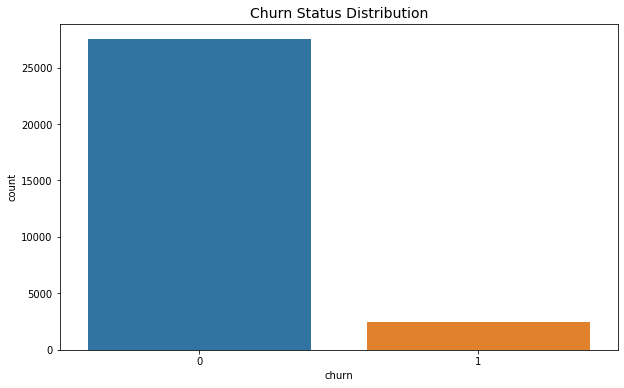

In [45]:
sns.countplot(telecom_df.churn)
plt.title('Churn Status Distribution',fontsize=14)
print(telecom_df['churn'].value_counts()/telecom_df.shape[0])



Since only 8% customers have churned, we can infer that data is imbalanced






Imbalance data distribution is an important part of machine learning workflow. An imbalanced dataset means instances of one of the two classes is higher than the other, in another way, the number of observations is not the same for all the classes in a classification dataset.


In [46]:
# Mobile Number

telecom_df.mobile_number.nunique()

29953

#### There are 29953 unique values for the mobile number and we can ignore this column from analysis

## Average Revenue per user

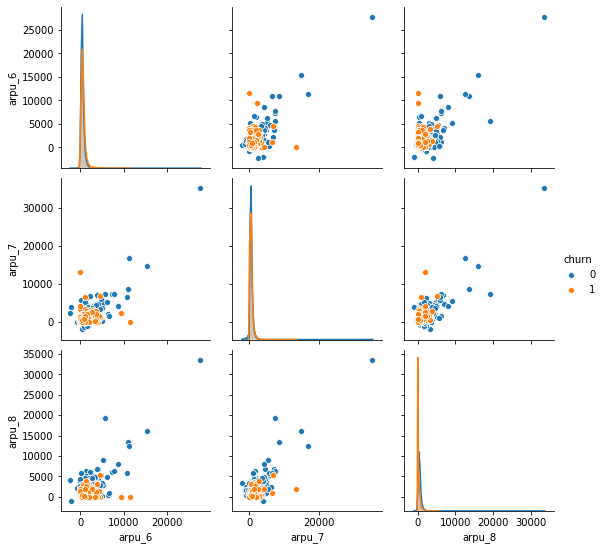

In [47]:
sns.pairplot(data = telecom_df[['arpu_6','arpu_7','arpu_8','churn']],hue = 'churn')

In [48]:
#plot with Inter Quartile treatment for Outliers
def plotAnalysis(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 4))
    ax = sns.distplot(telecom_df[telecom_df['churn']==1][feature], bins = 30, ax = axes[0], kde = True)
    ax.set_title('Churn')
    ax = sns.distplot(telecom_df[telecom_df['churn']==0][feature], bins = 30, ax = axes[1], kde = True)
    ax.set_title('Non-Churn')
    q1 = telecom_df[feature].quantile(0.25)
    q3 = telecom_df[feature].quantile(0.75)
    qr = q3 - q1
    telecom_df_new = telecom_df[(telecom_df[feature] > (q1 - 1.5 * qr ))  & (telecom_df[feature] < (q3 + 1.5 * qr )) ]
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(12, 4))
    sns.boxplot(x='churn', y= feature, data=telecom_df_new)

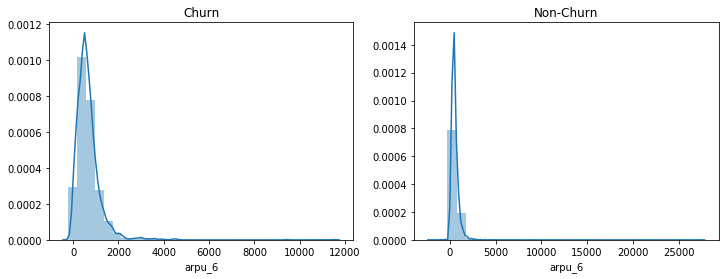

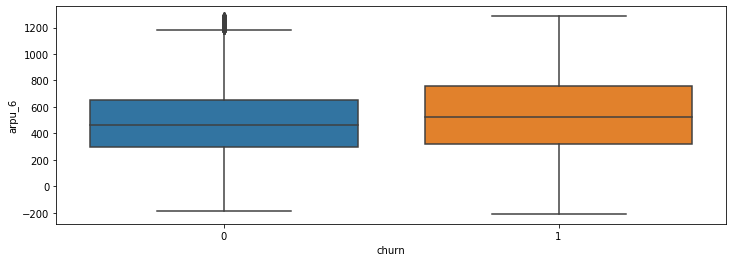

In [49]:
plotAnalysis('arpu_6')

We could see that after Outlier treatment,the mean Average Revenue per User for not churned customers is around 450 and for churned customers is around 425

## Onnet_mou (On network/ within the same network usage)

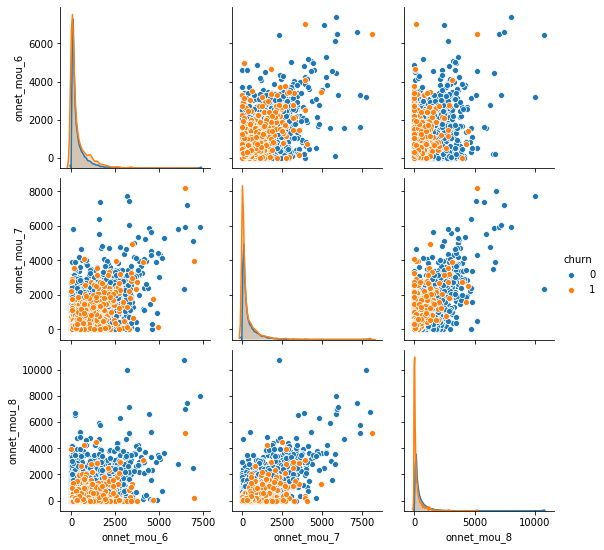

In [50]:
sns.pairplot(data = telecom_df[['onnet_mou_6','onnet_mou_7','onnet_mou_8','churn']],hue = 'churn')

In [51]:
## Offnet_mou (Calls outside of the operator network)

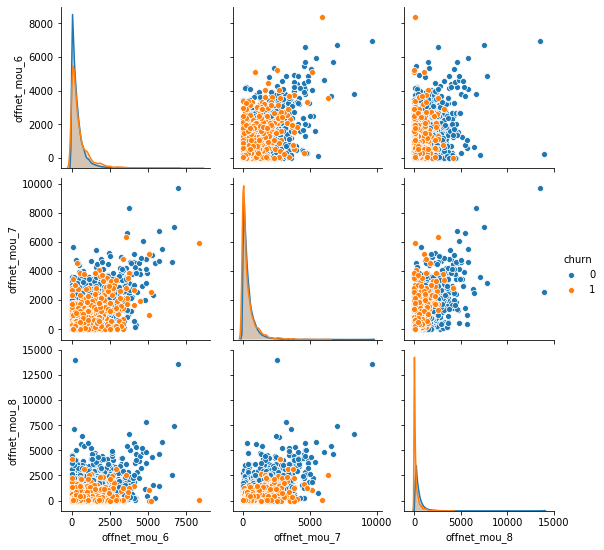

In [52]:
sns.pairplot(data=telecom_df[['offnet_mou_6','offnet_mou_7','offnet_mou_8','churn']],hue='churn')

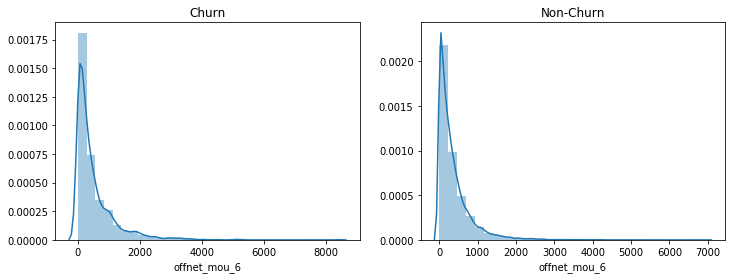

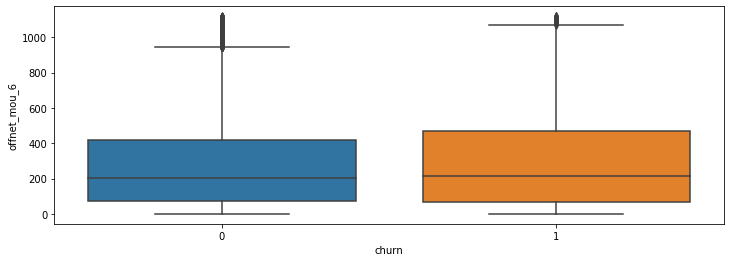

In [53]:
plotAnalysis('offnet_mou_6')

We could see that after Outlier treatment, mean number of calls outside of the operator network made by not churned customers is around 200 and churned customers is around 180

In [54]:
## roam_ic_mou (Customer in roaming zone)

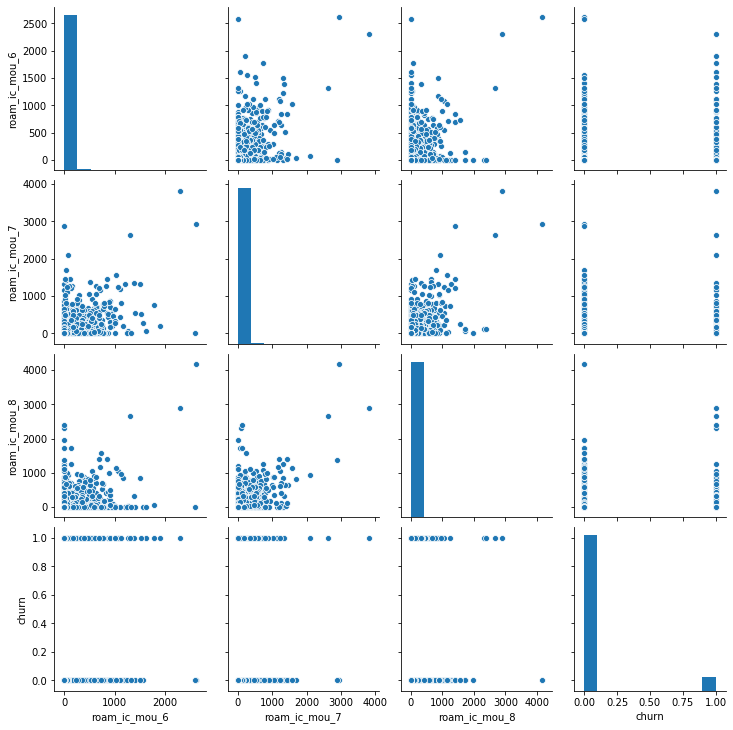

In [55]:
sns.pairplot(data=telecom_df[['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','churn']])

In [56]:
## isd_og (international calling)

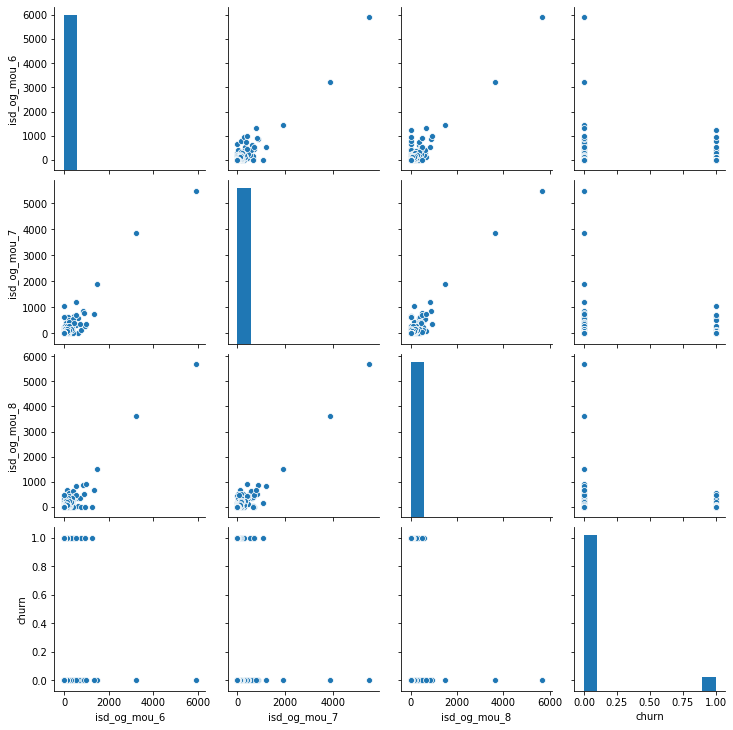

In [57]:
sns.pairplot(data=telecom_df[['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','churn']])

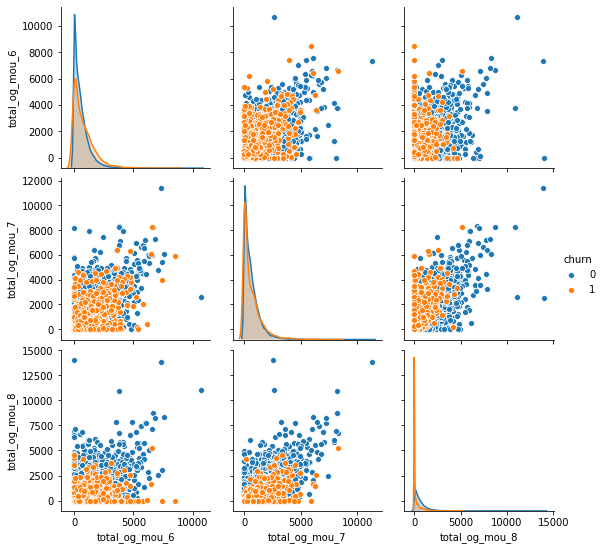

In [58]:
sns.pairplot(data=telecom_df[['total_og_mou_6','total_og_mou_7','total_og_mou_8','churn']],hue='churn')

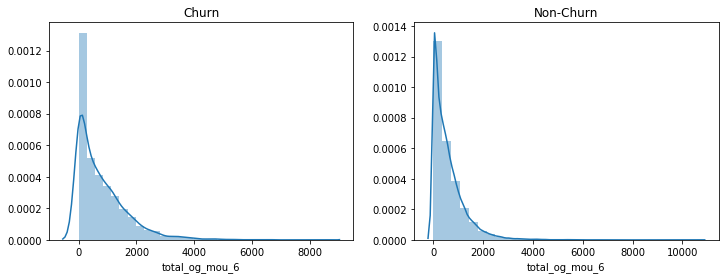

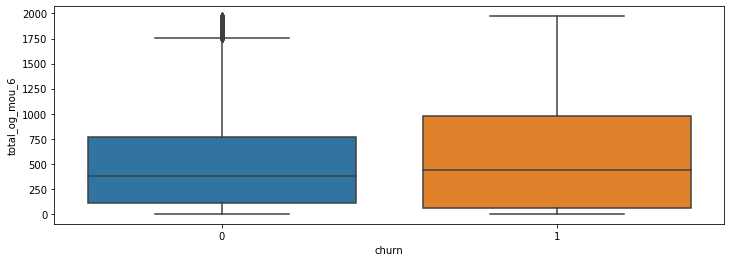

In [59]:
# Plotting all outgoing calls by the customer for the Month of June

plotAnalysis('total_og_mou_6')

We could see that after Outlier treatment, mean number of outgoing calls made by not churned customers is around 300 and churned customers is around 200

In [60]:
## locic (incoming local calls)

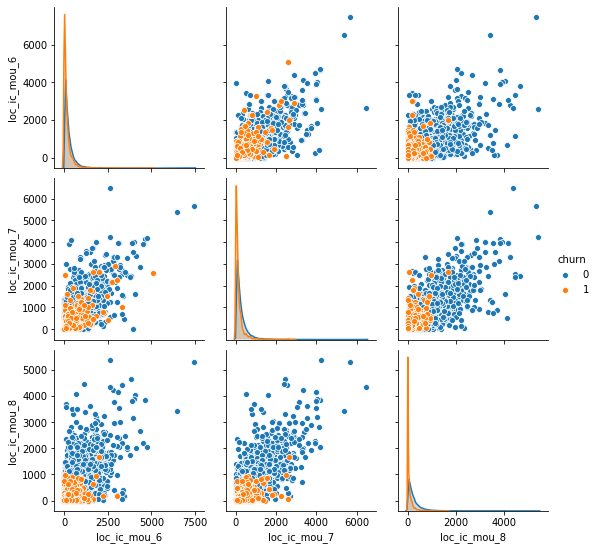

In [61]:
sns.pairplot(data=telecom_df[['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','churn']],hue='churn')

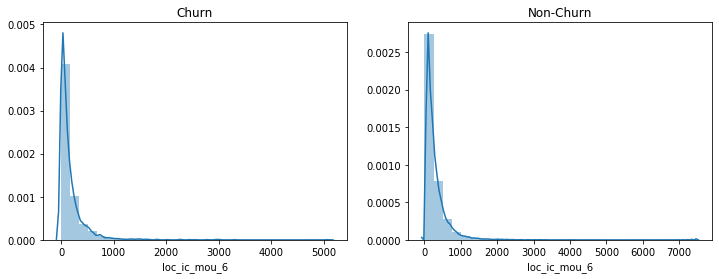

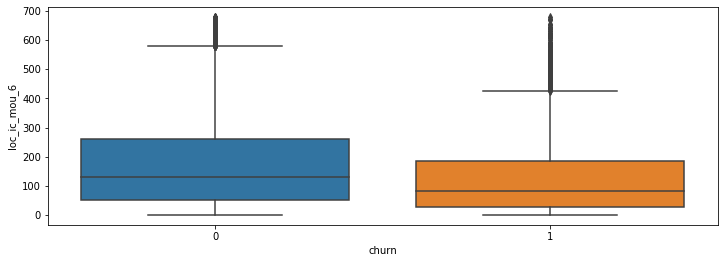

In [62]:
plotAnalysis('loc_ic_mou_6')

We could see that after Outlier treatment, mean number of incoming calls received by not churned customers is around 120 and churned customers is around 70

In [63]:
## stdic (Outside circle incoming calls)

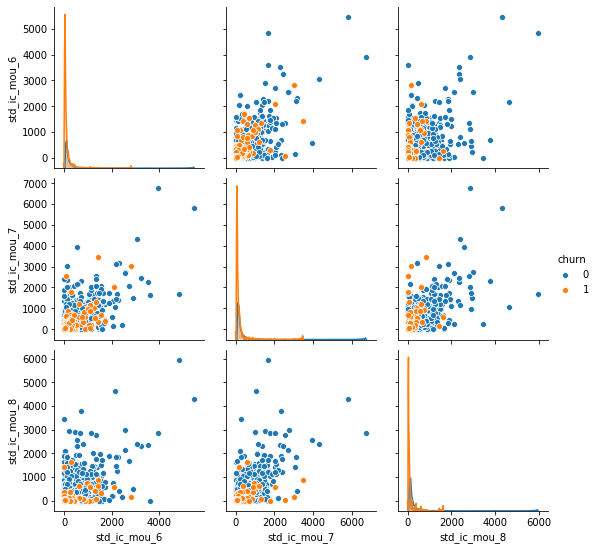

In [64]:
sns.pairplot(data=telecom_df[['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','churn']],hue='churn')

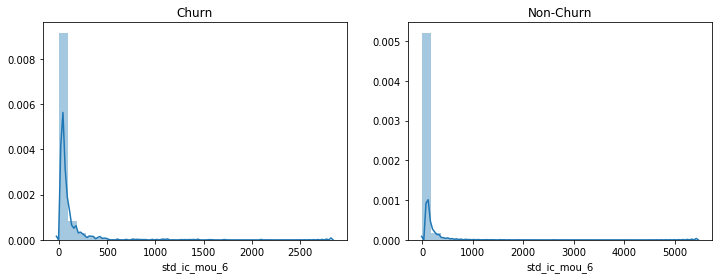

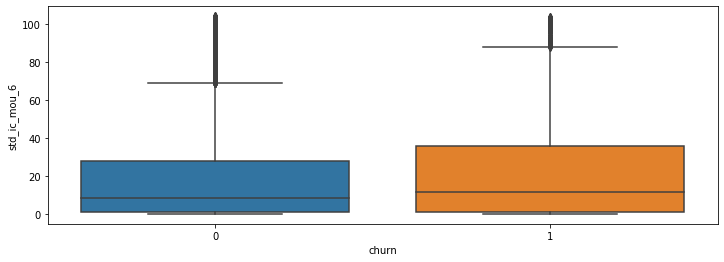

In [65]:
plotAnalysis('std_ic_mou_6')

We could see that after Outlier treatment, mean number of Outside circle incoming calls received by not churned customers is around 15 and churned customers is around 10

In [66]:
## totalic (All incoming calls received by a person)

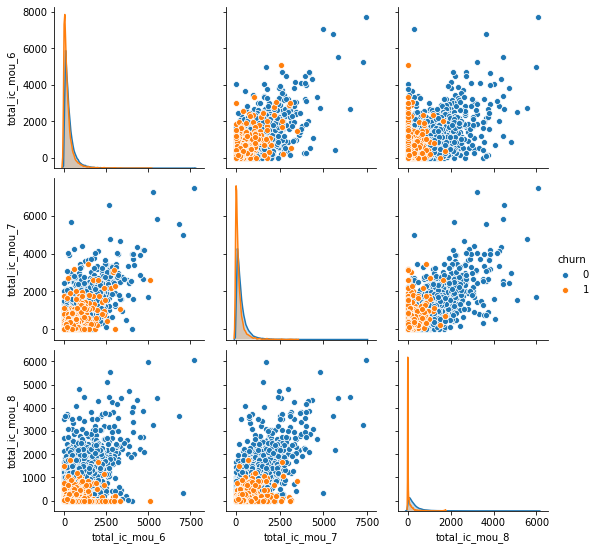

In [67]:
sns.pairplot(data=telecom_df[['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','churn']],hue='churn')


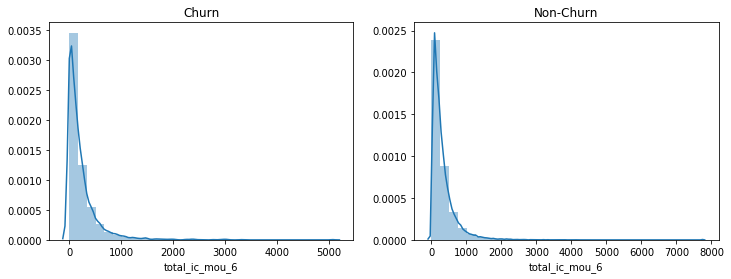

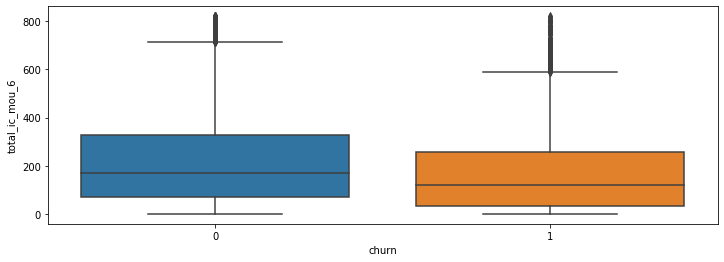

In [68]:
plotAnalysis('total_ic_mou_6')

We could see that after Outlier treatment, mean number of all incoming calls received by not churned customers is around 185 and churned customers is around 150

In [69]:
## total_rechnum (Number of times a subscriber recharged his mobile)

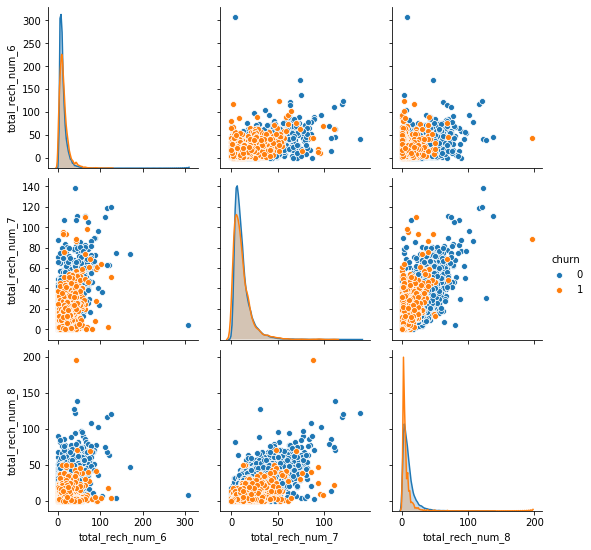

In [70]:
sns.pairplot(data=telecom_df[['total_rech_num_6','total_rech_num_7','total_rech_num_8','churn']],hue='churn')

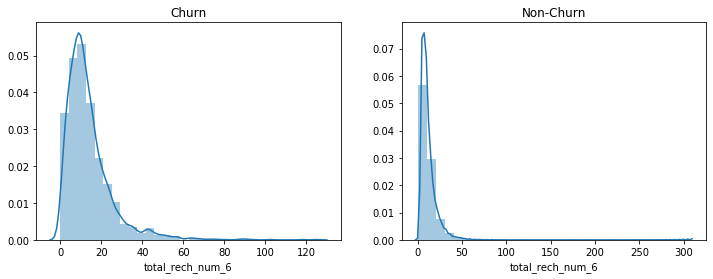

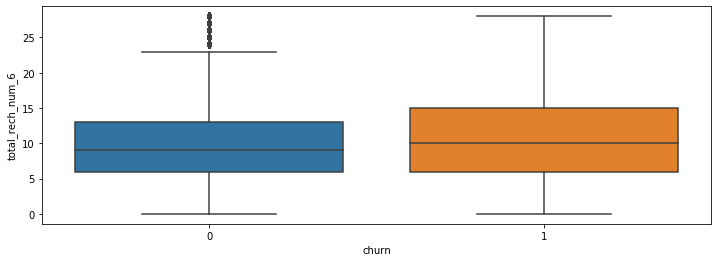

In [71]:
plotAnalysis('total_rech_num_6')

We could see that after Outlier treatment, in the month of June, mean number of recharges made by not churned customers is around 9 and that made by churned customers is around 7

In [72]:
## total_rechamt (Total recharge amount in a particular month)

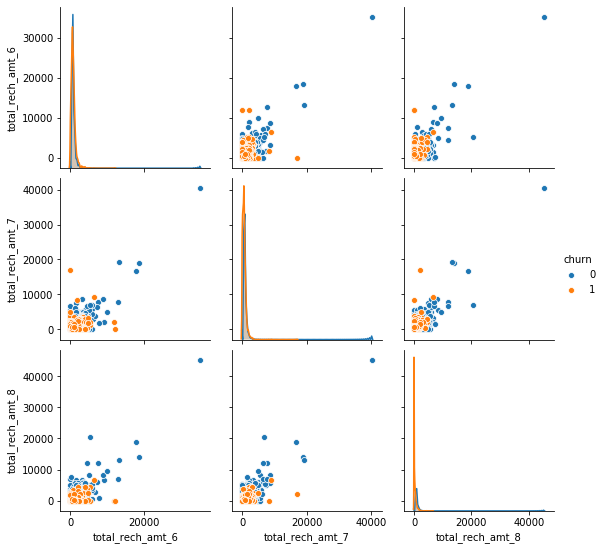

In [73]:
sns.pairplot(data=telecom_df[['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','churn']],hue='churn')

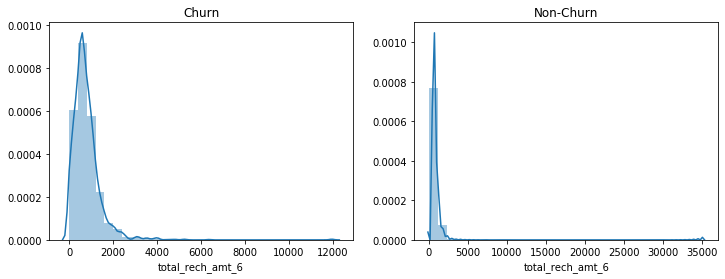

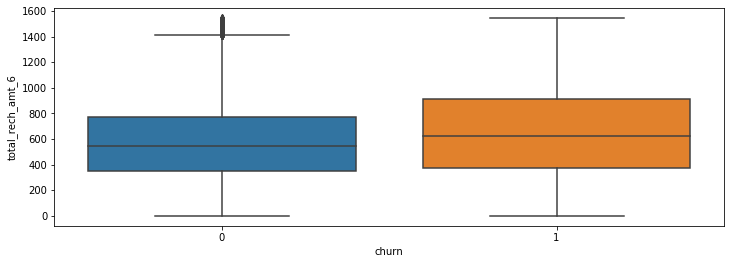

In [74]:
plotAnalysis('total_rech_amt_6')

We could see that after Outlier treatment, in the month of June, mean of total recharge amount made by not churned customers is around 590 and that made by churned customers is around 550

In [75]:
## total_rechdata (Total number of times mobile data has been recharged)

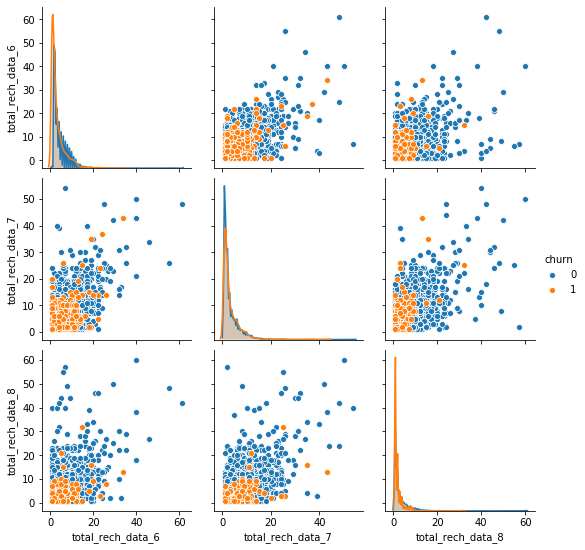

In [76]:
sns.pairplot(data=telecom_df[['total_rech_data_6','total_rech_data_7','total_rech_data_8','churn']],hue='churn')

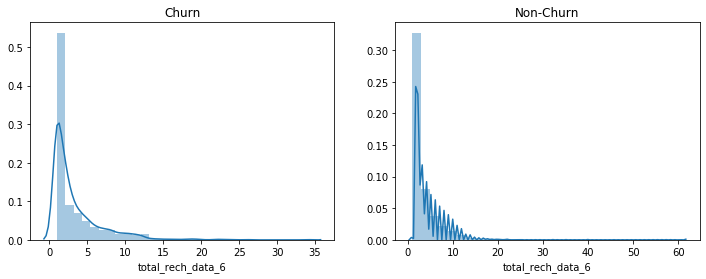

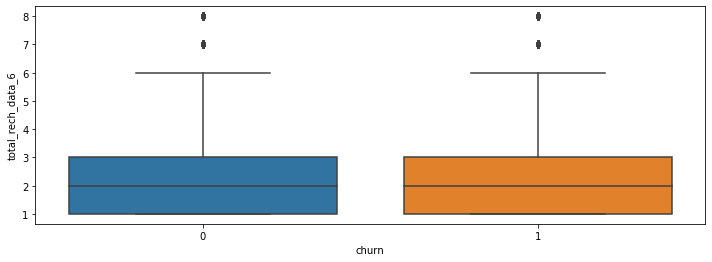

In [77]:
plotAnalysis('total_rech_data_6')

We could see that after Outlier treatment, in the month of June, mean of total number of times mobile data has been recharged by not churned customers is around 2 and that made by churned customers is also around 2

In [78]:
## vol_2gmb (Internet usage in MB)

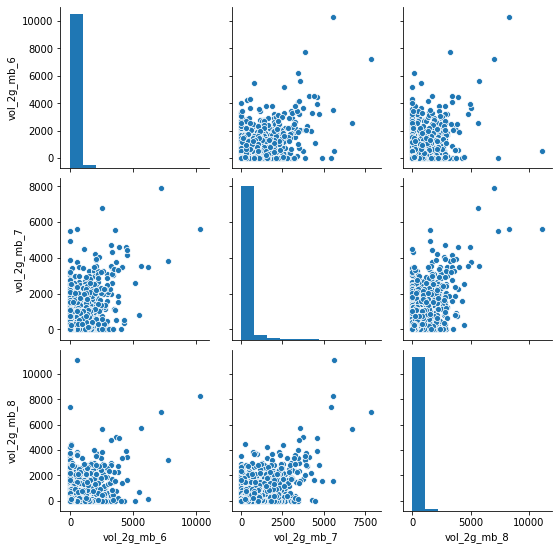

In [79]:
sns.pairplot(data=telecom_df[['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8']])

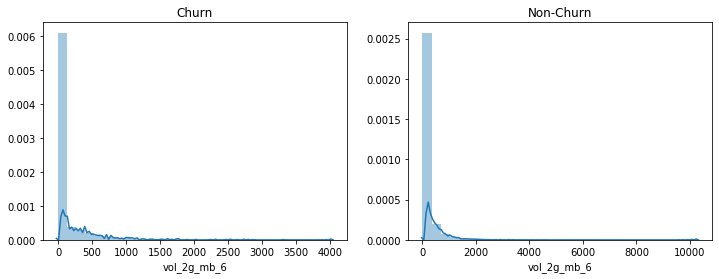

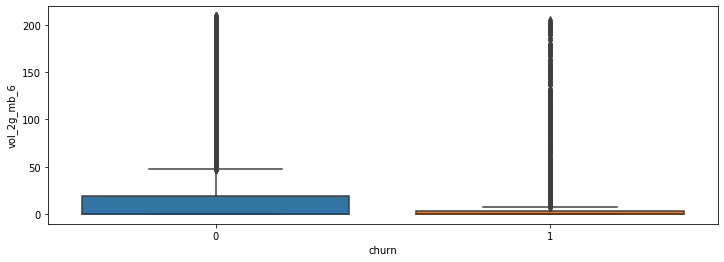

In [80]:
plotAnalysis('vol_2g_mb_6')

In [81]:
## vol_3gmb - (Internet usage in MB)

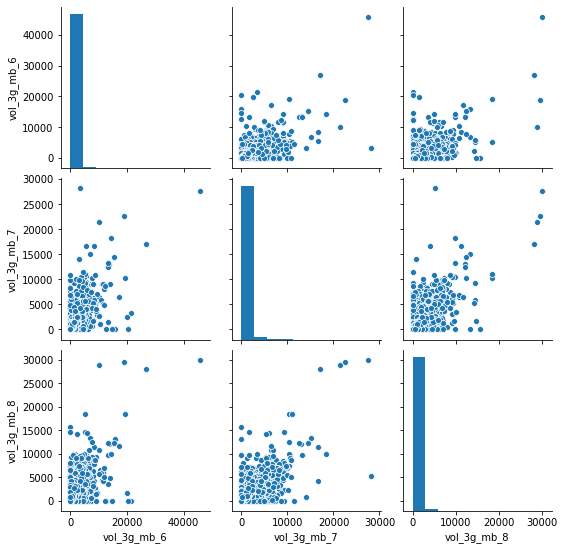

In [82]:
sns.pairplot(data=telecom_df[['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8']])

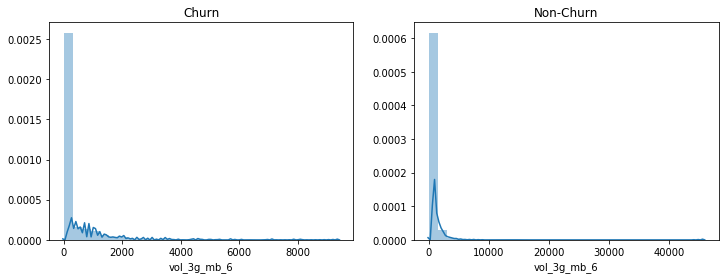

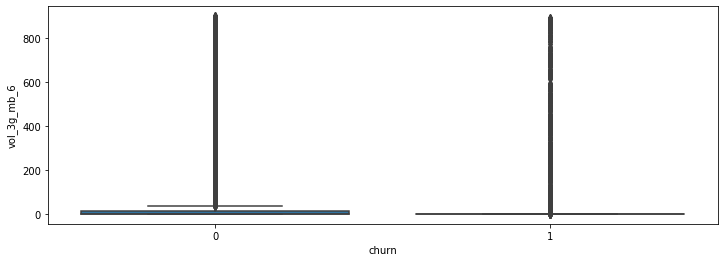

In [83]:
plotAnalysis('vol_3g_mb_6')

In [84]:
## vbc3g (Volume based cost - paid as per usage)

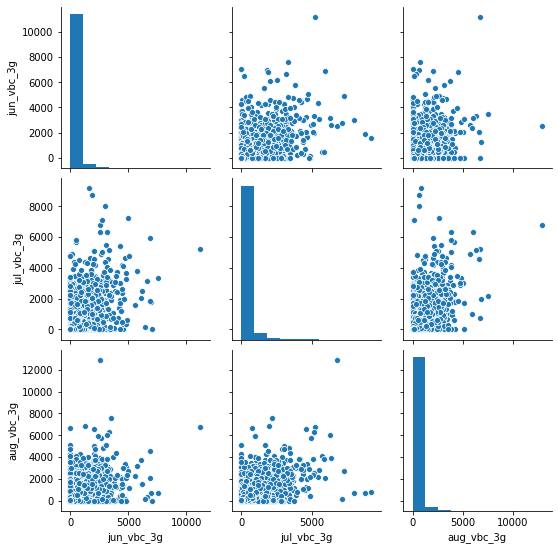

In [85]:
sns.pairplot(data=telecom_df[['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g']])

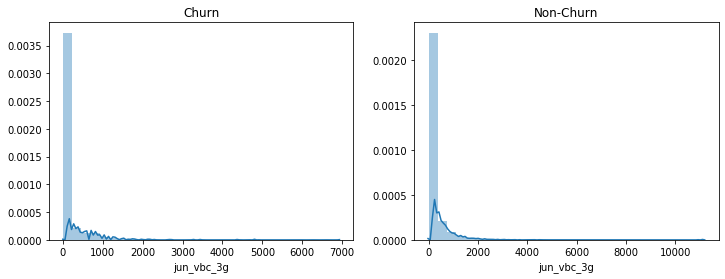

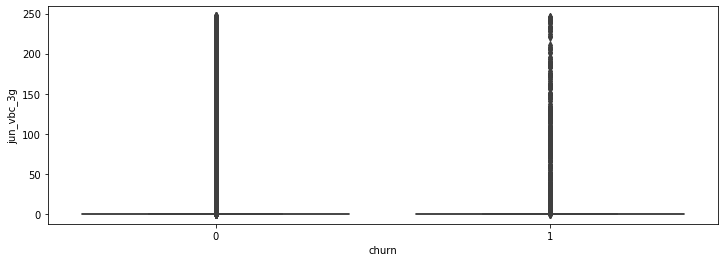

In [86]:
plotAnalysis('jun_vbc_3g')

Across the features, the behaviours are different. But both churned and not churned customer's behavior across every fetures are almost same. Therefore none of the above analysed features could not be ignored for Model Building

## Derived Features

In [87]:
# Formatting various Date features

telecom_df['date_of_last_rech_6'] = pd.to_datetime(telecom_df['date_of_last_rech_6'])
telecom_df['date_of_last_rech_7'] = pd.to_datetime(telecom_df['date_of_last_rech_7'])
telecom_df['date_of_last_rech_8'] = pd.to_datetime(telecom_df['date_of_last_rech_8'])

In [88]:
telecom_df['mobile_number'] = telecom_df['mobile_number'].astype(str)

In [89]:
telecom_df.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_6,total_data_rech_7,amt_data_6,amt_data_7,AVG_amt_data_6_7,churn
0,7000842753,197.38,214.82,213.80,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,0.00,nan,nan,0.16,nan,nan,4.13,nan,nan,1.15,nan,nan,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,0.00,0.00,5.44,nan,nan,0.00,nan,nan,0.00,nan,nan,0.00,4,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,252.00,252.00,614.00,504.00,559.00,1
1,7000701601,1069.18,1349.85,3171.48,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.00,0.00,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,802,57.74,19.38,18.74,nan,nan,1580.00,790.00,1185.00,1
2,7001524846,378.

In [90]:
# Print all date related columns
print(telecom_df.filter(regex = 'date',axis = 1).columns)
telecom_df.filter(regex = 'date',axis = 1).head()

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')


,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
0,2014-06-21,2014-07-16,2014-08-08
1,2014-06-27,2014-07-25,2014-08-26
2,2014-06-25,2014-07-31,2014-08-30
3,2014-06-30,2014-07-31,2014-08-31
4,2014-06-18,2014-07-07,2014-08-24


In [91]:
telecom_df.info(verbose= True,null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29953 entries, 0 to 29952
Data columns (total 161 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   mobile_number        29953 non-null  object        
 1   arpu_6               29953 non-null  float64       
 2   arpu_7               29953 non-null  float64       
 3   arpu_8               29953 non-null  float64       
 4   onnet_mou_6          29411 non-null  float64       
 5   onnet_mou_7          29417 non-null  float64       
 6   onnet_mou_8          28781 non-null  float64       
 7   offnet_mou_6         29411 non-null  float64       
 8   offnet_mou_7         29417 non-null  float64       
 9   offnet_mou_8         28781 non-null  float64       
 10  roam_ic_mou_6        29411 non-null  float64       
 11  roam_ic_mou_7        29417 non-null  float64       
 12  roam_ic_mou_8        28781 non-null  float64       
 13  roam_og_mou_6        29411 non

In [92]:
joincorr= telecom_df.corr()
telecom_df_corr = joincorr.stack().reset_index().sort_values(by = 0, ascending = False)
telecom_df_corr[((telecom_df_corr[0] < 1) & (telecom_df_corr[0] >= 0.4)) | ((telecom_df_corr[0] <= -0.4) & (telecom_df_corr[0] > -1))]

,level_0,level_1,0
21619,sachet_2g_8,count_rech_2g_8,0.99
17407,count_rech_2g_8,sachet_2g_8,0.99
17249,count_rech_2g_7,sachet_2g_7,0.99
21461,sachet_2g_7,count_rech_2g_7,0.99
17091,count_rech_2g_6,sachet_2g_6,0.98
21303,sachet_2g_6,count_rech_2g_6,0.98
24018,total_data_rech_7,amt_data_7,0.97
24330,amt_data_7,total_data_rech_7,0.97
23860,total_data_rech_6,amt_data_6,0.97
24172,amt_data_6,total_data_rech_6,0.97


In [93]:
telecom_df['AVG_arpu_6_7'] = telecom_df[['arpu_6','arpu_7']].mean(axis=1)
telecom_df['is_arpu_flag'] = np.where((telecom_df['arpu_8'] > telecom_df['AVG_arpu_6_7']), 0, 1)

telecom_df['AVG_onnet_mou_6_7'] = telecom_df[['onnet_mou_6','onnet_mou_7']].mean(axis=1)
telecom_df['is_onnet_mou_flag'] = np.where((telecom_df['onnet_mou_8'] > telecom_df['AVG_onnet_mou_6_7']), 0, 1)

telecom_df['AVG_offnet_mou_6_7'] = telecom_df[['offnet_mou_6','offnet_mou_7']].mean(axis=1)
telecom_df['is_offnet_mou_flag'] = np.where((telecom_df['offnet_mou_8'] > telecom_df['AVG_offnet_mou_6_7']), 0, 1)

telecom_df['AVG_roam_ic_mou_6_7'] = telecom_df[['roam_ic_mou_6','roam_ic_mou_7']].mean(axis=1)
telecom_df['is_roam_ic_mou_flag'] = np.where((telecom_df['roam_ic_mou_8'] > telecom_df['AVG_roam_ic_mou_6_7']), 0, 1)

telecom_df['AVG_roam_og_mou_6_7'] = telecom_df[['roam_og_mou_6','roam_og_mou_7']].mean(axis=1)
telecom_df['is_roam_og_mou_flag'] = np.where((telecom_df['roam_og_mou_8'] > telecom_df['AVG_roam_og_mou_6_7']), 0, 1)

telecom_df['AVG_loc_og_t2t_mou_6_7'] = telecom_df[['loc_og_t2t_mou_6','loc_og_t2t_mou_7']].mean(axis=1)
telecom_df['is_loc_og_t2t_mou_flag'] = np.where((telecom_df['loc_og_t2t_mou_8'] > telecom_df['AVG_loc_og_t2t_mou_6_7']), 0, 1)

telecom_df['AVG_loc_og_t2m_mou_6_7'] = telecom_df[['loc_og_t2m_mou_6','loc_og_t2m_mou_7']].mean(axis=1)
telecom_df['is_loc_og_t2m_mou_flag'] = np.where((telecom_df['loc_og_t2m_mou_8'] > telecom_df['AVG_loc_og_t2m_mou_6_7']), 0, 1)

telecom_df['AVG_loc_og_t2f_mou_6_7'] = telecom_df[['loc_og_t2f_mou_6','loc_og_t2f_mou_7']].mean(axis=1)
telecom_df['is_loc_og_t2f_mou_flag'] = np.where((telecom_df['loc_og_t2f_mou_8'] > telecom_df['AVG_loc_og_t2f_mou_6_7']), 0, 1)

telecom_df['AVG_loc_og_t2c_mou_6_7'] = telecom_df[['loc_og_t2c_mou_6','loc_og_t2c_mou_7']].mean(axis=1)
telecom_df['is_loc_og_t2c_mou_flag'] = np.where((telecom_df['loc_og_t2c_mou_8'] > telecom_df['AVG_loc_og_t2c_mou_6_7']), 0, 1)

telecom_df['AVG_std_og_t2t_mou_6_7'] = telecom_df[['std_og_t2t_mou_6','std_og_t2t_mou_7']].mean(axis=1)
telecom_df['is_std_og_t2t_mou_flag'] = np.where((telecom_df['std_og_t2t_mou_8'] > telecom_df['AVG_std_og_t2t_mou_6_7']), 0, 1)

telecom_df['AVG_std_og_t2m_mou_6_7'] = telecom_df[['std_og_t2m_mou_6','std_og_t2m_mou_7']].mean(axis=1)
telecom_df['is_std_og_t2m_mou_flag'] = np.where((telecom_df['std_og_t2m_mou_8'] > telecom_df['AVG_std_og_t2m_mou_6_7']), 0, 1)

telecom_df['AVG_std_og_t2f_mou_6_7'] = telecom_df[['std_og_t2f_mou_6','std_og_t2f_mou_7']].mean(axis=1)
telecom_df['is_std_og_t2f_mou_flag'] = np.where((telecom_df['std_og_t2f_mou_8'] > telecom_df['AVG_std_og_t2f_mou_6_7']), 0, 1)

telecom_df['AVG_isd_og_mou_6_7'] = telecom_df[['isd_og_mou_6','isd_og_mou_7']].mean(axis=1)
telecom_df['is_isd_og_mou_flag'] = np.where((telecom_df['isd_og_mou_8'] > telecom_df['AVG_isd_og_mou_6_7']), 0, 1)

telecom_df['AVG_spl_og_mou_6_7'] = telecom_df[['spl_og_mou_6','spl_og_mou_7']].mean(axis=1)
telecom_df['is_spl_og_mou_flag'] = np.where((telecom_df['spl_og_mou_8'] > telecom_df['AVG_spl_og_mou_6_7']), 0, 1)

telecom_df['AVG_og_others_6_7'] = telecom_df[['og_others_6','og_others_7']].mean(axis=1)
telecom_df['is_og_others_flag'] = np.where((telecom_df['og_others_8'] > telecom_df['AVG_og_others_6_7']), 0, 1)


telecom_df['AVG_loc_ic_t2t_mou_6_7'] = telecom_df[['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7']].mean(axis=1)
telecom_df['is_loc_ic_t2t_mou_flag'] = np.where((telecom_df['loc_ic_t2t_mou_8'] > telecom_df['AVG_loc_ic_t2t_mou_6_7']), 0, 1)

telecom_df['AVG_loc_ic_t2m_mou_6_7'] = telecom_df[['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7']].mean(axis=1)
telecom_df['is_loc_ic_t2m_mou_flag'] = np.where((telecom_df['loc_ic_t2m_mou_8'] > telecom_df['AVG_loc_ic_t2m_mou_6_7']), 0, 1)

telecom_df['AVG_loc_ic_t2f_mou_6_7'] = telecom_df[['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7']].mean(axis=1)
telecom_df['is_loc_ic_t2f_mou_flag'] = np.where((telecom_df['loc_ic_t2f_mou_8'] > telecom_df['AVG_loc_ic_t2f_mou_6_7']), 0, 1)

telecom_df['AVG_std_ic_t2t_mou_6_7'] = telecom_df[['std_ic_t2t_mou_6','std_ic_t2t_mou_7']].mean(axis=1)
telecom_df['is_std_ic_t2t_mou_flag'] = np.where((telecom_df['std_ic_t2t_mou_8'] > telecom_df['AVG_std_ic_t2t_mou_6_7']), 0, 1)

telecom_df['AVG_std_ic_t2m_mou_6_7'] = telecom_df[['std_ic_t2m_mou_6','std_ic_t2m_mou_7']].mean(axis=1)
telecom_df['is_std_ic_t2m_mou_flag'] = np.where((telecom_df['std_ic_t2m_mou_8'] > telecom_df['AVG_std_ic_t2m_mou_6_7']), 0, 1)

telecom_df['AVG_std_ic_t2f_mou_6_7'] = telecom_df[['std_ic_t2f_mou_6','std_ic_t2f_mou_7']].mean(axis=1)
telecom_df['is_std_ic_t2f_mou_flag'] = np.where((telecom_df['std_ic_t2f_mou_8'] > telecom_df['AVG_std_ic_t2f_mou_6_7']), 0, 1)

telecom_df['AVG_spl_ic_mou_6_7'] = telecom_df[['spl_ic_mou_6','spl_ic_mou_7']].mean(axis=1)
telecom_df['is_spl_ic_mou_flag'] = np.where((telecom_df['spl_ic_mou_8'] > telecom_df['AVG_spl_ic_mou_6_7']), 0, 1)

telecom_df['AVG_isd_ic_mou_6_7'] = telecom_df[['isd_ic_mou_6','isd_ic_mou_7']].mean(axis=1)
telecom_df['is_isd_ic_mou_flag'] = np.where((telecom_df['isd_ic_mou_8'] > telecom_df['AVG_isd_ic_mou_6_7']), 0, 1)

telecom_df['AVG_ic_others_6_7'] = telecom_df[['ic_others_6','ic_others_7']].mean(axis=1)
telecom_df['is_ic_others_flag'] = np.where((telecom_df['ic_others_8'] > telecom_df['AVG_ic_others_6_7']), 0, 1)

telecom_df['AVG_total_rech_amt_6_7'] = telecom_df[['total_rech_amt_6','total_rech_amt_7']].mean(axis=1)
telecom_df['is_total_rech_amt_flag'] = np.where((telecom_df['total_rech_amt_8'] > telecom_df['AVG_total_rech_amt_6_7']), 0, 1)

telecom_df['AVG_vol_2g_mb_6_7'] = telecom_df[['vol_2g_mb_6','vol_2g_mb_7']].mean(axis=1)
telecom_df['is_vol_2g_mb_flag'] = np.where((telecom_df['vol_2g_mb_8'] > telecom_df['AVG_vol_2g_mb_6_7']), 0, 1)

telecom_df['AVG_vol_3g_mb_6_7'] = telecom_df[['vol_3g_mb_6','vol_3g_mb_7']].mean(axis=1)
telecom_df['is_vol_3g_mb_flag'] = np.where((telecom_df['vol_3g_mb_8'] > telecom_df['AVG_vol_3g_mb_6_7']), 0, 1)

telecom_df['AVG_arpu_3g_6_7'] = telecom_df[['arpu_3g_6','arpu_3g_7']].mean(axis=1)
telecom_df['is_arpu_3g_flag'] = np.where((telecom_df['arpu_3g_8'] > telecom_df['AVG_arpu_3g_6_7']), 0, 1)

telecom_df['AVG_arpu_2g_6_7'] = telecom_df[['arpu_2g_6','arpu_2g_7']].mean(axis=1)
telecom_df['is_arpu_2g_flag'] = np.where((telecom_df['arpu_2g_8'] > telecom_df['AVG_arpu_2g_6_7']), 0, 1)

telecom_df['AVG_vbc_3g_6_7'] = telecom_df[['jun_vbc_3g','jul_vbc_3g']].mean(axis=1)
telecom_df['is_vbc_3g_flag'] = np.where((telecom_df['aug_vbc_3g'] > telecom_df['AVG_vbc_3g_6_7']), 0, 1)

telecom_df['AVG_loc_og_mou_6_7'] = telecom_df[['loc_og_mou_6','loc_og_mou_7']].mean(axis=1)
telecom_df['is_loc_og_mou_flag'] = np.where((telecom_df['loc_og_mou_8'] > telecom_df['AVG_loc_og_mou_6_7']), 0, 1)

telecom_df['AVG_std_og_mou_6_7'] = telecom_df[['std_og_mou_6','std_og_mou_7']].mean(axis=1)
telecom_df['is_std_og_mou_flag'] = np.where((telecom_df['std_og_mou_8'] > telecom_df['AVG_std_og_mou_6_7']), 0, 1)

telecom_df['AVG_total_og_mou_6_7'] = telecom_df[['total_og_mou_6','total_og_mou_7']].mean(axis=1)
telecom_df['is_total_og_mou_flag'] = np.where((telecom_df['total_og_mou_8'] > telecom_df['AVG_total_og_mou_6_7']), 0, 1)

telecom_df['AVG_loc_ic_mou_6_7'] = telecom_df[['loc_ic_mou_6','loc_ic_mou_7']].mean(axis=1)
telecom_df['is_loc_ic_mou_flag'] = np.where((telecom_df['loc_ic_mou_8'] > telecom_df['AVG_loc_ic_mou_6_7']), 0, 1)

telecom_df['AVG_std_ic_mou_6_7'] = telecom_df[['std_ic_mou_6','std_ic_mou_7']].mean(axis=1)
telecom_df['is_std_ic_mou_flag'] = np.where((telecom_df['std_ic_mou_8'] > telecom_df['AVG_std_ic_mou_6_7']), 0, 1)

telecom_df['AVG_total_ic_mou_6_7'] = telecom_df[['total_ic_mou_6','total_ic_mou_7']].mean(axis=1)
telecom_df['is_total_ic_mou_flag'] = np.where((telecom_df['total_ic_mou_8'] > telecom_df['AVG_total_ic_mou_6_7']), 0, 1)

telecom_df['AVG_night_pck_user_6_7'] = telecom_df[['night_pck_user_6','night_pck_user_7']].mean(axis=1)
telecom_df['is_night_pck_user_flag'] = np.where((telecom_df['night_pck_user_8'] > telecom_df['AVG_night_pck_user_6_7']), 0, 1)

telecom_df['AVG_monthly_2g_6_7'] = telecom_df[['monthly_2g_6','monthly_2g_7']].mean(axis=1)
telecom_df['is_monthly_2g_flag'] = np.where((telecom_df['monthly_2g_8'] > telecom_df['AVG_monthly_2g_6_7']), 0, 1)

telecom_df['AVG_sachet_2g_6_7'] = telecom_df[['sachet_2g_6','sachet_2g_7']].mean(axis=1)
telecom_df['is_sachet_2g_flag'] = np.where((telecom_df['sachet_2g_8'] > telecom_df['AVG_sachet_2g_6_7']), 0, 1)

telecom_df['AVG_monthly_3g_6_7'] = telecom_df[['monthly_3g_6','monthly_3g_7']].mean(axis=1)
telecom_df['is_monthly_3g_flag'] = np.where((telecom_df['monthly_3g_8'] > telecom_df['AVG_monthly_3g_6_7']), 0, 1)

telecom_df['AVG_sachet_3g_6_7'] = telecom_df[['sachet_3g_6','sachet_3g_7']].mean(axis=1)
telecom_df['is_sachet_3g_flag'] = np.where((telecom_df['sachet_3g_8'] > telecom_df['AVG_sachet_3g_6_7']), 0, 1)

telecom_df['AVG_fb_user_6_7'] = telecom_df[['fb_user_6','fb_user_7']].mean(axis=1)
telecom_df['is_fb_user_flag'] = np.where((telecom_df['fb_user_8'] > telecom_df['AVG_fb_user_6_7']), 0, 1)


In [94]:
# Create month on month change features to undersatnd any risk associated with it

# Create month on month change features to understand any risk associated with the churn
telecom_df['loc_og_t2t_mou_7diff6'] = telecom_df['loc_og_t2t_mou_7'] - telecom_df['loc_og_t2t_mou_6']
telecom_df['loc_og_t2m_mou_7diff6'] = telecom_df['loc_og_t2m_mou_7'] - telecom_df['loc_og_t2m_mou_6']
telecom_df['loc_og_t2f_mou_7diff6'] = telecom_df['loc_og_t2f_mou_7'] - telecom_df['loc_og_t2f_mou_6']
telecom_df['loc_og_t2c_mou_7diff6'] = telecom_df['loc_og_t2c_mou_7'] - telecom_df['loc_og_t2c_mou_6']
telecom_df['loc_og_mou_7diff6'] = telecom_df['loc_og_mou_7'] - telecom_df['loc_og_mou_6']
telecom_df['std_og_t2t_mou_7diff6'] = telecom_df['std_og_t2t_mou_7'] - telecom_df['std_og_t2t_mou_6']
telecom_df['std_og_t2m_mou_7diff6'] = telecom_df['std_og_t2m_mou_7'] - telecom_df['std_og_t2m_mou_6']
telecom_df['std_og_t2f_mou_7diff6'] = telecom_df['std_og_t2f_mou_7'] - telecom_df['std_og_t2f_mou_6']
telecom_df['std_og_mou_7diff6'] = telecom_df['std_og_mou_7'] - telecom_df['std_og_mou_6']
telecom_df['loc_og_mou_7diff6'] = telecom_df['loc_og_mou_7'] - telecom_df['loc_og_mou_6']
telecom_df['std_og_mou_7diff6'] = telecom_df['std_og_mou_7'] - telecom_df['std_og_mou_6']
telecom_df['isd_og_mou_7diff6'] = telecom_df['isd_og_mou_7'] - telecom_df['isd_og_mou_6']
telecom_df['spl_og_mou_7diff6'] = telecom_df['spl_og_mou_7'] - telecom_df['spl_og_mou_6']
telecom_df['og_others_7diff6'] = telecom_df['og_others_7'] - telecom_df['og_others_6']
telecom_df['total_og_mou_7diff6'] = telecom_df['total_og_mou_7'] - telecom_df['total_og_mou_6']

telecom_df['loc_og_t2t_mou_8diff7'] = telecom_df['loc_og_t2t_mou_8'] - telecom_df['loc_og_t2t_mou_7']
telecom_df['loc_og_t2m_mou_8diff7'] = telecom_df['loc_og_t2m_mou_8'] - telecom_df['loc_og_t2m_mou_7']
telecom_df['loc_og_t2f_mou_8diff7'] = telecom_df['loc_og_t2f_mou_8'] - telecom_df['loc_og_t2f_mou_7']
telecom_df['loc_og_t2c_mou_8diff7'] = telecom_df['loc_og_t2c_mou_8'] - telecom_df['loc_og_t2c_mou_7']
telecom_df['loc_og_mou_8diff7'] = telecom_df['loc_og_mou_8'] - telecom_df['loc_og_mou_7']
telecom_df['std_og_t2t_mou_8diff7'] = telecom_df['std_og_t2t_mou_8'] - telecom_df['std_og_t2t_mou_7']
telecom_df['std_og_t2m_mou_8diff7'] = telecom_df['std_og_t2m_mou_8'] - telecom_df['std_og_t2m_mou_7']
telecom_df['std_og_t2f_mou_8diff7'] = telecom_df['std_og_t2f_mou_8'] - telecom_df['std_og_t2f_mou_7']
telecom_df['std_og_mou_8diff7'] = telecom_df['std_og_mou_8'] - telecom_df['std_og_mou_7']
telecom_df['loc_og_mou_8diff7'] = telecom_df['loc_og_mou_8'] - telecom_df['loc_og_mou_7']
telecom_df['std_og_mou_8diff7'] = telecom_df['std_og_mou_8'] - telecom_df['std_og_mou_7']
telecom_df['isd_og_mou_8diff7'] = telecom_df['isd_og_mou_8'] - telecom_df['isd_og_mou_7']
telecom_df['spl_og_mou_8diff7'] = telecom_df['spl_og_mou_8'] - telecom_df['spl_og_mou_7']
telecom_df['og_others_8diff7'] = telecom_df['og_others_8'] - telecom_df['og_others_7']
telecom_df['total_og_mou_8diff7'] = telecom_df['total_og_mou_8'] - telecom_df['total_og_mou_7']

telecom_df['loc_ic_t2t_mou_7diff6'] = telecom_df['loc_ic_t2t_mou_7'] - telecom_df['loc_ic_t2t_mou_6']
telecom_df['loc_ic_t2m_mou_7diff6'] = telecom_df['loc_ic_t2m_mou_7'] - telecom_df['loc_ic_t2m_mou_6']
telecom_df['loc_ic_t2f_mou_7diff6'] = telecom_df['loc_ic_t2f_mou_7'] - telecom_df['loc_ic_t2f_mou_6']
telecom_df['loc_ic_mou_7diff6'] = telecom_df['loc_ic_mou_7'] - telecom_df['loc_ic_mou_6']
telecom_df['std_ic_t2t_mou_7diff6'] = telecom_df['std_ic_t2t_mou_7'] - telecom_df['std_ic_t2t_mou_6']
telecom_df['std_ic_t2m_mou_7diff6'] = telecom_df['std_ic_t2m_mou_7'] - telecom_df['std_ic_t2m_mou_6']
telecom_df['std_ic_t2f_mou_7diff6'] = telecom_df['std_ic_t2f_mou_7'] - telecom_df['std_ic_t2f_mou_6']
telecom_df['std_ic_mou_7diff6'] = telecom_df['std_ic_mou_7'] - telecom_df['std_ic_mou_6']
telecom_df['loc_ic_mou_7diff6'] = telecom_df['loc_ic_mou_7'] - telecom_df['loc_ic_mou_6']
telecom_df['std_ic_mou_7diff6'] = telecom_df['std_ic_mou_7'] - telecom_df['std_ic_mou_6']
telecom_df['spl_ic_mou_7diff6'] = telecom_df['spl_ic_mou_7'] - telecom_df['spl_ic_mou_6']
telecom_df['isd_ic_mou_7diff6'] = telecom_df['isd_ic_mou_7'] - telecom_df['isd_ic_mou_6']
telecom_df['ic_others_7diff6'] = telecom_df['ic_others_7'] - telecom_df['ic_others_6']
telecom_df['total_ic_mou_7diff6'] = telecom_df['total_ic_mou_7'] - telecom_df['total_ic_mou_6']

telecom_df['loc_ic_t2t_mou_8diff7'] = telecom_df['loc_ic_t2t_mou_8'] - telecom_df['loc_ic_t2t_mou_7']
telecom_df['loc_ic_t2m_mou_8diff7'] = telecom_df['loc_ic_t2m_mou_8'] - telecom_df['loc_ic_t2m_mou_7']
telecom_df['loc_ic_t2f_mou_8diff7'] = telecom_df['loc_ic_t2f_mou_8'] - telecom_df['loc_ic_t2f_mou_7']
telecom_df['loc_ic_mou_8diff7'] = telecom_df['loc_ic_mou_8'] - telecom_df['loc_ic_mou_7']
telecom_df['std_ic_t2t_mou_8diff7'] = telecom_df['std_ic_t2t_mou_8'] - telecom_df['std_ic_t2t_mou_7']
telecom_df['std_ic_t2m_mou_8diff7'] = telecom_df['std_ic_t2m_mou_8'] - telecom_df['std_ic_t2m_mou_7']
telecom_df['std_ic_t2f_mou_8diff7'] = telecom_df['std_ic_t2f_mou_8'] - telecom_df['std_ic_t2f_mou_7']
telecom_df['std_ic_mou_8diff7'] = telecom_df['std_ic_mou_8'] - telecom_df['std_ic_mou_7']
telecom_df['loc_ic_mou_8diff7'] = telecom_df['loc_ic_mou_8'] - telecom_df['loc_ic_mou_7']
telecom_df['std_ic_mou_8diff7'] = telecom_df['std_ic_mou_8'] - telecom_df['std_ic_mou_7']
telecom_df['spl_ic_mou_8diff7'] = telecom_df['spl_ic_mou_8'] - telecom_df['spl_ic_mou_7']
telecom_df['isd_ic_mou_8diff7'] = telecom_df['isd_ic_mou_8'] - telecom_df['isd_ic_mou_7']
telecom_df['ic_others_8diff7'] = telecom_df['ic_others_8'] - telecom_df['ic_others_7']
telecom_df['total_ic_mou_8diff7'] = telecom_df['total_ic_mou_8'] - telecom_df['total_ic_mou_7']

telecom_df['onnet_mou_7diff6'] = telecom_df['onnet_mou_7'] - telecom_df['onnet_mou_6']
telecom_df['onnet_mou_8diff7'] = telecom_df['onnet_mou_8'] - telecom_df['onnet_mou_7']

telecom_df['offnet_mou_7diff6'] = telecom_df['offnet_mou_7'] - telecom_df['offnet_mou_6']
telecom_df['offnet_mou_8diff7'] = telecom_df['offnet_mou_8'] - telecom_df['offnet_mou_7']

telecom_df['roam_ic_mou_7diff6'] = telecom_df['roam_ic_mou_7'] - telecom_df['roam_ic_mou_6']
telecom_df['roam_ic_mou_8diff7'] = telecom_df['roam_ic_mou_8'] - telecom_df['roam_ic_mou_7']

telecom_df['roam_og_mou_7diff6'] = telecom_df['roam_og_mou_7'] - telecom_df['roam_og_mou_6']
telecom_df['roam_og_mou_8diff7'] = telecom_df['roam_og_mou_8'] - telecom_df['roam_og_mou_7']

telecom_df['total_rech_amt_7diff6'] = telecom_df['total_rech_amt_7'] - telecom_df['total_rech_amt_6']
telecom_df['total_rech_amt_8diff7'] = telecom_df['total_rech_amt_8'] - telecom_df['total_rech_amt_7']

telecom_df['date_of_last_rech_7diff6'] = (telecom_df['date_of_last_rech_7'] - telecom_df['date_of_last_rech_6']).dt.days
telecom_df['date_of_last_rech_8diff7'] = (telecom_df['date_of_last_rech_8'] - telecom_df['date_of_last_rech_7']).dt.days

telecom_df['vol_2g_mb_7diff6'] = telecom_df['vol_2g_mb_7'] - telecom_df['vol_2g_mb_6']
telecom_df['vol_2g_mb_8diff7'] = telecom_df['vol_2g_mb_8'] - telecom_df['vol_2g_mb_7']

telecom_df['vol_3g_mb_7diff6'] = telecom_df['vol_3g_mb_7'] - telecom_df['vol_3g_mb_6']
telecom_df['vol_3g_mb_8diff7'] = telecom_df['vol_3g_mb_8'] - telecom_df['vol_3g_mb_7']

telecom_df['vbc_3g_7diff6'] = telecom_df['jul_vbc_3g'] - telecom_df['jun_vbc_3g']
telecom_df['vbc_3g_8diff7'] = telecom_df['aug_vbc_3g'] - telecom_df['jul_vbc_3g']


## Feature Selection

Let's drop date related features as we derived new features out of it

In [95]:
telecom_df.shape

(29953, 313)

In [96]:
telecom_df.drop(list(telecom_df.select_dtypes(include=['datetime64']).columns),axis=1,inplace=True)
telecom_df.shape

(29953, 310)

In [97]:
# Since we have the good data for both month 6, 7 as average, we dont need the raw columns, so dropping them

telecom_df.drop(['arpu_6','arpu_7','onnet_mou_6','onnet_mou_7','offnet_mou_6','offnet_mou_7',
         'roam_ic_mou_6','roam_ic_mou_7','roam_og_mou_6','roam_og_mou_7',
         'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2m_mou_6','loc_og_t2m_mou_7',
         'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2c_mou_6','loc_og_t2c_mou_7',
         'std_og_t2t_mou_6','std_og_t2t_mou_7', 'std_og_t2m_mou_6','std_og_t2m_mou_7',
         'std_og_t2f_mou_6','std_og_t2f_mou_7','isd_og_mou_6','isd_og_mou_7',
         'spl_og_mou_6','spl_og_mou_7', 'og_others_6','og_others_7',
         'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7',
         'loc_ic_t2f_mou_6','loc_ic_t2f_mou_7', 'std_ic_t2t_mou_6','std_ic_t2t_mou_7',
         'std_ic_t2m_mou_6','std_ic_t2m_mou_7', 'std_ic_t2f_mou_6','std_ic_t2f_mou_7',
         'spl_ic_mou_6','spl_ic_mou_7', 'isd_ic_mou_6','isd_ic_mou_7',
         'ic_others_6','ic_others_7', 'total_rech_amt_6','total_rech_amt_7',
         'vol_2g_mb_6','vol_2g_mb_7', 'vol_3g_mb_6','vol_3g_mb_7',
         'arpu_3g_6','arpu_3g_7', 'arpu_2g_6','arpu_2g_7',
         'jun_vbc_3g','jul_vbc_3g', 'loc_og_mou_6', 'loc_og_mou_7','std_og_mou_6', 'std_og_mou_7',
          'total_og_mou_6', 'total_og_mou_7','loc_ic_mou_6', 'loc_ic_mou_7',
          'std_ic_mou_6', 'std_ic_mou_7','total_ic_mou_6', 'total_ic_mou_7',
          'total_rech_num_6', 'total_rech_num_7','night_pck_user_6', 'night_pck_user_7',
          'monthly_2g_6', 'monthly_2g_7','sachet_2g_6', 'sachet_2g_7',
          'monthly_3g_6', 'monthly_3g_7','sachet_3g_6', 'sachet_3g_7','fb_user_6', 'fb_user_7'
        ], axis=1, inplace=True)

In [98]:
telecom_df.shape

(29953, 224)

In [99]:
corr_matrix = telecom_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [100]:
telecom_df.drop(columns=to_drop, axis=1,inplace=True)

In [101]:
telecom_df.shape

(29953, 195)

In [102]:
def corr_metrix(dataset):
    corr = dataset.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap='RdYlGn')

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
    ax.tick_params(labelsize=20)

def corr_2_more_visualize(dataset):
    corr = dataset.corr()
    
    f, ax = plt.subplots(figsize=(20, 9))
    sns.heatmap(corr.apply(lambda x : np.round(x,2)), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True,cmap='RdYlGn', annot_kws={"size": 15})
    ax.tick_params(labelsize=20)
    plt.show()
    

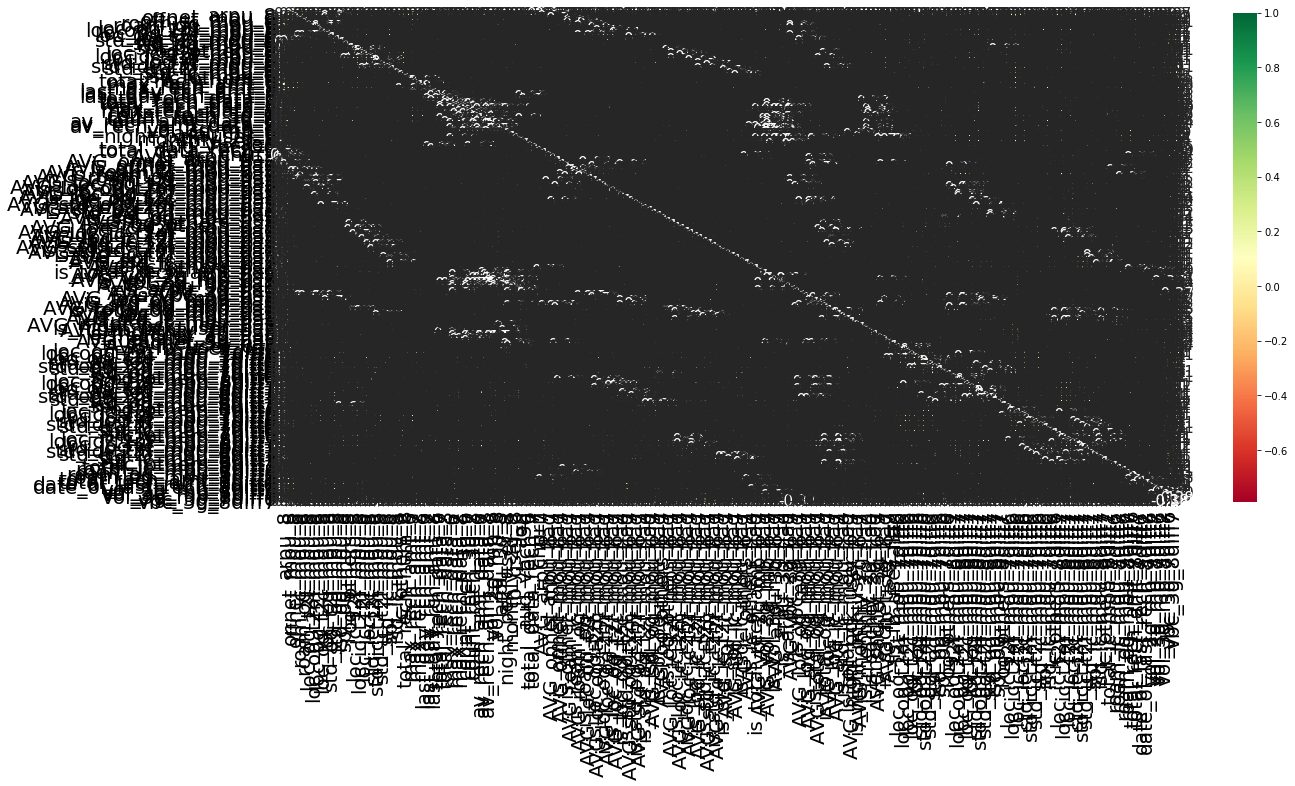

In [292]:
corr_2_more_visualize(telecom_df)

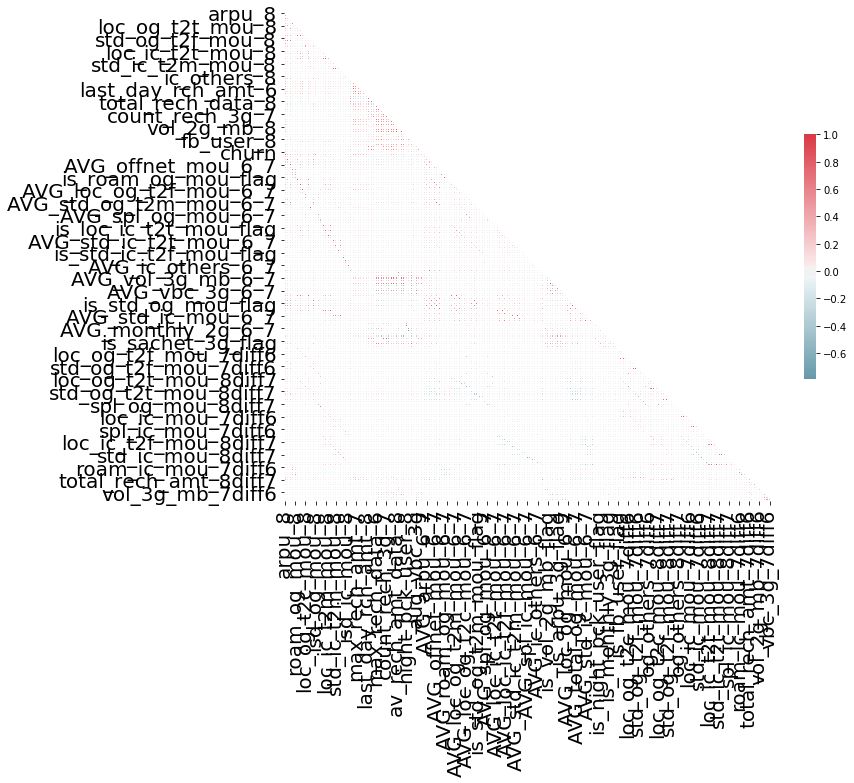

In [291]:
corr_metrix(telecom_df)

In [103]:
Counter(telecom_df.churn)

Counter({1: 2433, 0: 27520})

[Text(0, 0.5, '(%)')]

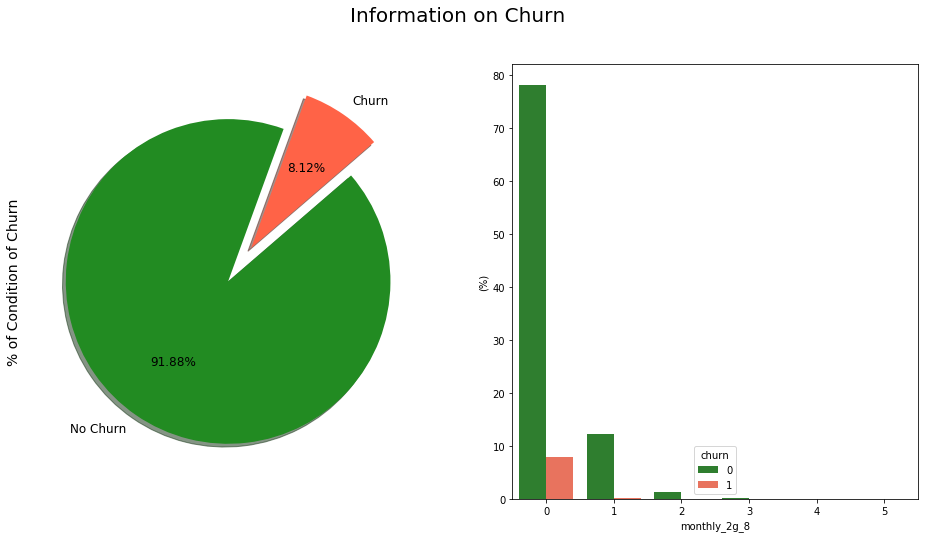

In [104]:

f, ax = plt.subplots(1,2, figsize=(16,8))
colors = ["#228B22", "#FF6347"]

labels ="No Churn", "Churn"
plt.suptitle('Information on Churn', fontsize=20)

telecom_df["churn"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', ax=ax[0], shadow=True, 
                                    colors=colors, labels=labels, fontsize=12, startangle=70)
ax[0].set_ylabel('% of Condition of Churn', fontsize=14)

palette = ["#228B22", "#FF6347"]


sns.barplot(x="monthly_2g_8", y="churn", hue="churn", data=telecom_df, palette=palette, 
            estimator=lambda x: len(x) / len(telecom_df) * 100)
ax[1].set(ylabel="(%)")

In [105]:
# Removing all category columns

list(telecom_df.select_dtypes(include=['category']).columns)

[]

In [106]:
telecom_df.drop(columns = list(telecom_df.select_dtypes(include=['category']).columns), axis =1, inplace = True)

In [107]:
# Removing all object columns

list(telecom_df.select_dtypes(include=[object]).columns)

['mobile_number']

In [108]:
print(telecom_df.shape)
telecom_df.drop(columns = list(telecom_df.select_dtypes(include=[object]).columns), axis = 1, inplace = True)
print(telecom_df.shape)

(29953, 195)
(29953, 194)


In [109]:
telecom_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29953 entries, 0 to 29952
Data columns (total 194 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   arpu_8                    float64
 1   onnet_mou_8               float64
 2   offnet_mou_8              float64
 3   roam_ic_mou_8             float64
 4   roam_og_mou_8             float64
 5   loc_og_t2t_mou_8          float64
 6   loc_og_t2m_mou_8          float64
 7   loc_og_t2f_mou_8          float64
 8   loc_og_t2c_mou_8          float64
 9   loc_og_mou_8              float64
 10  std_og_t2f_mou_8          float64
 11  std_og_mou_8              float64
 12  isd_og_mou_8              float64
 13  spl_og_mou_8              float64
 14  og_others_8               float64
 15  loc_ic_t2t_mou_8          float64
 16  loc_ic_t2m_mou_8          float64
 17  loc_ic_t2f_mou_8          float64
 18  loc_ic_mou_8              float64
 19  std_ic_t2t_mou_8          float64
 20  std_ic_t2m_mou_8          f

In [110]:
# Replace all missing values with zero as discussed above

telecom_df.replace([np.inf, -np.inf], np.nan,inplace=True)
telecom_df.fillna(0,inplace=True)

In [111]:
telecom_df.isnull().values.any()

False

In [112]:
telecom_df.shape

(29953, 194)

# <font color = 'blue'>EDA Completed.

# <font color = 'Red'> Imbalanced Dataset

In [113]:
def majority_imbalanced_dataset(dataset, target_col):
    feature_columns = dataset.columns.tolist()
    feature_columns = [c for c in feature_columns if c not in [target_col]]

    X2_new = dataset[feature_columns]
    Y2_new = dataset[target_col]

    os =  RandomOverSampler(random_state=35)
    X_feature_variables , y_output = os.fit_sample(X2_new, Y2_new)
    
    X_feature_variables[target_col] = y_output
    
    X_feature_variables = X_feature_variables.sample(frac = 1).reset_index(drop = True)
    
    return X_feature_variables


In [114]:
print(Counter(telecom_df.churn))

df = majority_imbalanced_dataset(telecom_df.copy(), "churn")

print(Counter(df.churn))

Counter({0: 27520, 1: 2433})
Counter({0: 27520, 1: 27520})


## Model Building

In [115]:
X = df.drop('churn',axis= 1)
Y = df.churn

In [117]:
X.info(verbose=1) # X data types are int and float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55040 entries, 0 to 55039
Data columns (total 193 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   arpu_8                    float64
 1   onnet_mou_8               float64
 2   offnet_mou_8              float64
 3   roam_ic_mou_8             float64
 4   roam_og_mou_8             float64
 5   loc_og_t2t_mou_8          float64
 6   loc_og_t2m_mou_8          float64
 7   loc_og_t2f_mou_8          float64
 8   loc_og_t2c_mou_8          float64
 9   loc_og_mou_8              float64
 10  std_og_t2f_mou_8          float64
 11  std_og_mou_8              float64
 12  isd_og_mou_8              float64
 13  spl_og_mou_8              float64
 14  og_others_8               float64
 15  loc_ic_t2t_mou_8          float64
 16  loc_ic_t2m_mou_8          float64
 17  loc_ic_t2f_mou_8          float64
 18  loc_ic_mou_8              float64
 19  std_ic_t2t_mou_8          float64
 20  std_ic_t2m_mou_8          f

In [118]:
X.head(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,night_pck_user_8,monthly_2g_8,fb_user_8,aon,aug_vbc_3g,total_data_rech_6,total_data_rech_7,AVG_arpu_6_7,is_arpu_flag,AVG_onnet_mou_6_7,is_onnet_mou_flag,AVG_offnet_mou_6_7,is_offnet_mou_flag,AVG_roam_ic_mou_6_7,is_roam_ic_mou_flag,AVG_roam_og_mou_6_7,is_roam_og_mou_flag,AVG_loc_og_t2t_mou_6_7,is_loc_og_t2t_mou_flag,AVG_loc_og_t2m_mou_6_7,is_loc_og_t2m_mou_flag,AVG_loc_og_t2f_mou_6_7,is_loc_og_t2f_mou_flag,AVG_loc_og_t2c_mou_6_7,is_loc_og_t2c_mou_flag,is_std_og_t2t_mou_flag,AVG_std_og_t2m_mou_6_7,is_std_og_t2m_mou_flag,AVG_std_og_t2f_mou_6_7,is_std_og_t2f_mou_flag,is_isd_og_mou_flag,AVG_spl_og_mou_6_7,is_spl_og_mou_flag,AVG_og_others_6_7,is_og_others_flag,AVG_loc_ic_t2t_mou_6_7,is_loc_ic_t2t_mou_flag,AVG_loc_ic_t2m_mou_6_7,is_loc_ic_t2m_mou_flag,AVG_loc_ic_t2f_mou_6_7,is_loc_ic_t2f_mou_flag,AVG_std_ic_t2t_mou_6_7,is_std_ic_t2t_mou_flag,AVG_std_ic_t2m_mou_6_7,is_std_ic_t2m_mou_flag,AVG_std_ic_t2f_mou_6_7,is_std_ic_t2f_mou_flag,AVG_spl_ic_mou_6_7,is_spl_ic_mou_flag,AVG_isd_ic_mou_6_7,is_isd_ic_mou_flag,AVG_ic_others_6_7,is_ic_others_flag,is_total_rech_amt_flag,AVG_vol_2g_mb_6_7,is_vol_2g_mb_flag,AVG_vol_3g_mb_6_7,is_vol_3g_mb_flag,AVG_arpu_3g_6_7,is_arpu_3g_flag,is_arpu_2g_flag,AVG_vbc_3g_6_7,is_vbc_3g_flag,AVG_loc_og_mou_6_7,is_loc_og_mou_flag,AVG_std_og_mou_6_7,is_std_og_mou_flag,AVG_total_og_mou_6_7,is_total_og_mou_flag,AVG_loc_ic_mou_6_7,is_loc_ic_mou_flag,AVG_std_ic_mou_6_7,is_std_ic_mou_flag,is_total_ic_mou_flag,AVG_night_pck_user_6_7,is_night_pck_user_flag,AVG_monthly_2g_6_7,is_monthly_2g_flag,is_sachet_2g_flag,is_monthly_3g_flag,AVG_sachet_3g_6_7,is_sachet_3g_flag,AVG_fb_user_6_7,is_fb_user_flag,loc_og_t2t_mou_7diff6,loc_og_t2m_mou_7diff6,loc_og_t2f_mou_7diff6,loc_og_t2c_mou_7diff6,loc_og_mou_7diff6,std_og_t2t_mou_7diff6,std_og_t2m_mou_7diff6,std_og_t2f_mou_7diff6,std_og_mou_7diff6,isd_og_mou_7diff6,spl_og_mou_7diff6,og_others_7diff6,loc_og_t2t_mou_8diff7,loc_og_t2m_mou_8diff7,loc_og_t2f_mou_8diff7,loc_og_t2c_mou_8diff7,loc_og_mou_8diff7,std_og_t2t_mou_8diff7,std_og_t2m_mou_8diff7,std_og_t2f_mou_8diff7,std_og_mou_8diff7,isd_og_mou_8diff7,spl_og_mou_8diff7,og_others_8diff7,loc_ic_t2t_mou_7diff6,loc_ic_t2m_mou_7diff6,loc_ic_t2f_mou_7diff6,loc_ic_mou_7diff6,std_ic_t2t_mou_7diff6,std_ic_t2m_mou_7diff6,std_ic_t2f_mou_7diff6,std_ic_mou_7diff6,spl_ic_mou_7diff6,isd_ic_mou_7diff6,ic_others_7diff6,loc_ic_t2t_mou_8diff7,loc_ic_t2m_mou_8diff7,loc_ic_t2f_mou_8diff7,loc_ic_mou_8diff7,std_ic_t2t_mou_8diff7,std_ic_t2m_mou_8diff7,std_ic_t2f_mou_8diff7,std_ic_mou_8diff7,spl_ic_mou_8diff7,isd_ic_mou_8diff7,ic_others_8diff7,total_ic_mou_8diff7,roam_ic_mou_7diff6,roam_ic_mou_8diff7,roam_og_mou_7diff6,roam_og_mou_8diff7,total_rech_amt_7diff6,total_rech_amt_8diff7,date_of_last_rech_7diff6,date_of_last_rech_8diff7,vol_2g_mb_7diff6,vol_2g_mb_8diff7,vol_3g_mb_7diff6,vol_3g_mb_8diff7,vbc_3g_7diff6,vbc_3g_8diff7
0,388.45,343.98,328.38,0.00,0.00,33.84,88.58,0.00,0.00,122.43,0.00,549.93,0.00,0.00,0.00,38.31,192.01,0.38,230.71,6.24,8.04,0.00,14.29,0.00,0.00,14.13,8,1050,67,300,0,0,0,3.00,1.00,0.00,23.00,23.00,0.00,0.00,0.00,0.00,69.00,23.00,0.00,0.00,0.00,0.00,0.00,0,0.00,2634,0.00,207.00,23.00,689.30,1,561.39,1,514.06,1,0.00,1,0.00,1,91.03,1,115.66,1,0.67,1,0.00,1,1,397.18,1,0.00,1,1,0.55,1,0.00,1,78.91,1,272.20,1,0.97,1,6.58,1,

### Feature Scaling

In [119]:
scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

In [120]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=111)

In [121]:
def standardscaler_preprocessing(dataset_train, dataset_test):
    scaler = StandardScaler()
   
    dataset_train = scaler.fit_transform(dataset_train)

    dataset_test = scaler.transform(dataset_test)
    
    return dataset_train, dataset_test

In [122]:
X_train.head(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,night_pck_user_8,monthly_2g_8,fb_user_8,aon,aug_vbc_3g,total_data_rech_6,total_data_rech_7,AVG_arpu_6_7,is_arpu_flag,AVG_onnet_mou_6_7,is_onnet_mou_flag,AVG_offnet_mou_6_7,is_offnet_mou_flag,AVG_roam_ic_mou_6_7,is_roam_ic_mou_flag,AVG_roam_og_mou_6_7,is_roam_og_mou_flag,AVG_loc_og_t2t_mou_6_7,is_loc_og_t2t_mou_flag,AVG_loc_og_t2m_mou_6_7,is_loc_og_t2m_mou_flag,AVG_loc_og_t2f_mou_6_7,is_loc_og_t2f_mou_flag,AVG_loc_og_t2c_mou_6_7,is_loc_og_t2c_mou_flag,is_std_og_t2t_mou_flag,AVG_std_og_t2m_mou_6_7,is_std_og_t2m_mou_flag,AVG_std_og_t2f_mou_6_7,is_std_og_t2f_mou_flag,is_isd_og_mou_flag,AVG_spl_og_mou_6_7,is_spl_og_mou_flag,AVG_og_others_6_7,is_og_others_flag,AVG_loc_ic_t2t_mou_6_7,is_loc_ic_t2t_mou_flag,AVG_loc_ic_t2m_mou_6_7,is_loc_ic_t2m_mou_flag,AVG_loc_ic_t2f_mou_6_7,is_loc_ic_t2f_mou_flag,AVG_std_ic_t2t_mou_6_7,is_std_ic_t2t_mou_flag,AVG_std_ic_t2m_mou_6_7,is_std_ic_t2m_mou_flag,AVG_std_ic_t2f_mou_6_7,is_std_ic_t2f_mou_flag,AVG_spl_ic_mou_6_7,is_spl_ic_mou_flag,AVG_isd_ic_mou_6_7,is_isd_ic_mou_flag,AVG_ic_others_6_7,is_ic_others_flag,is_total_rech_amt_flag,AVG_vol_2g_mb_6_7,is_vol_2g_mb_flag,AVG_vol_3g_mb_6_7,is_vol_3g_mb_flag,AVG_arpu_3g_6_7,is_arpu_3g_flag,is_arpu_2g_flag,AVG_vbc_3g_6_7,is_vbc_3g_flag,AVG_loc_og_mou_6_7,is_loc_og_mou_flag,AVG_std_og_mou_6_7,is_std_og_mou_flag,AVG_total_og_mou_6_7,is_total_og_mou_flag,AVG_loc_ic_mou_6_7,is_loc_ic_mou_flag,AVG_std_ic_mou_6_7,is_std_ic_mou_flag,is_total_ic_mou_flag,AVG_night_pck_user_6_7,is_night_pck_user_flag,AVG_monthly_2g_6_7,is_monthly_2g_flag,is_sachet_2g_flag,is_monthly_3g_flag,AVG_sachet_3g_6_7,is_sachet_3g_flag,AVG_fb_user_6_7,is_fb_user_flag,loc_og_t2t_mou_7diff6,loc_og_t2m_mou_7diff6,loc_og_t2f_mou_7diff6,loc_og_t2c_mou_7diff6,loc_og_mou_7diff6,std_og_t2t_mou_7diff6,std_og_t2m_mou_7diff6,std_og_t2f_mou_7diff6,std_og_mou_7diff6,isd_og_mou_7diff6,spl_og_mou_7diff6,og_others_7diff6,loc_og_t2t_mou_8diff7,loc_og_t2m_mou_8diff7,loc_og_t2f_mou_8diff7,loc_og_t2c_mou_8diff7,loc_og_mou_8diff7,std_og_t2t_mou_8diff7,std_og_t2m_mou_8diff7,std_og_t2f_mou_8diff7,std_og_mou_8diff7,isd_og_mou_8diff7,spl_og_mou_8diff7,og_others_8diff7,loc_ic_t2t_mou_7diff6,loc_ic_t2m_mou_7diff6,loc_ic_t2f_mou_7diff6,loc_ic_mou_7diff6,std_ic_t2t_mou_7diff6,std_ic_t2m_mou_7diff6,std_ic_t2f_mou_7diff6,std_ic_mou_7diff6,spl_ic_mou_7diff6,isd_ic_mou_7diff6,ic_others_7diff6,loc_ic_t2t_mou_8diff7,loc_ic_t2m_mou_8diff7,loc_ic_t2f_mou_8diff7,loc_ic_mou_8diff7,std_ic_t2t_mou_8diff7,std_ic_t2m_mou_8diff7,std_ic_t2f_mou_8diff7,std_ic_mou_8diff7,spl_ic_mou_8diff7,isd_ic_mou_8diff7,ic_others_8diff7,total_ic_mou_8diff7,roam_ic_mou_7diff6,roam_ic_mou_8diff7,roam_og_mou_7diff6,roam_og_mou_8diff7,total_rech_amt_7diff6,total_rech_amt_8diff7,date_of_last_rech_7diff6,date_of_last_rech_8diff7,vol_2g_mb_7diff6,vol_2g_mb_8diff7,vol_3g_mb_7diff6,vol_3g_mb_8diff7,vbc_3g_7diff6,vbc_3g_8diff7
26817,268.70,22.93,72.79,0.00,0.00,22.93,71.71,0.00,0.00,94.64,1.08,1.08,0.00,0.00,0.00,25.68,187.38,3.36,216.43,1.06,0.00,14.53,15.59,0.00,0.00,0.00,12,14,154,98,14,30,30,1.00,5.00,4.00,14.00,154.00,98.00,0.00,0.00,0.00,14.00,254.00,154.00,197.58,166.23,0.00,0.00,0,1.00,1239,153.59,14.00,1270.00,132.50,0,8.32,0,48.74,0,0.00,1,0.00,1,8.32,0,32.16,0,0.00,1,2.96,1,1,0.00,1,0.52,0,1,16.07,1,0.00,1,35.92,1,167.76,0,7.82,1,

In [123]:
X_test.head(2)

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,arpu_3g_8,night_pck_user_8,monthly_2g_8,fb_user_8,aon,aug_vbc_3g,total_data_rech_6,total_data_rech_7,AVG_arpu_6_7,is_arpu_flag,AVG_onnet_mou_6_7,is_onnet_mou_flag,AVG_offnet_mou_6_7,is_offnet_mou_flag,AVG_roam_ic_mou_6_7,is_roam_ic_mou_flag,AVG_roam_og_mou_6_7,is_roam_og_mou_flag,AVG_loc_og_t2t_mou_6_7,is_loc_og_t2t_mou_flag,AVG_loc_og_t2m_mou_6_7,is_loc_og_t2m_mou_flag,AVG_loc_og_t2f_mou_6_7,is_loc_og_t2f_mou_flag,AVG_loc_og_t2c_mou_6_7,is_loc_og_t2c_mou_flag,is_std_og_t2t_mou_flag,AVG_std_og_t2m_mou_6_7,is_std_og_t2m_mou_flag,AVG_std_og_t2f_mou_6_7,is_std_og_t2f_mou_flag,is_isd_og_mou_flag,AVG_spl_og_mou_6_7,is_spl_og_mou_flag,AVG_og_others_6_7,is_og_others_flag,AVG_loc_ic_t2t_mou_6_7,is_loc_ic_t2t_mou_flag,AVG_loc_ic_t2m_mou_6_7,is_loc_ic_t2m_mou_flag,AVG_loc_ic_t2f_mou_6_7,is_loc_ic_t2f_mou_flag,AVG_std_ic_t2t_mou_6_7,is_std_ic_t2t_mou_flag,AVG_std_ic_t2m_mou_6_7,is_std_ic_t2m_mou_flag,AVG_std_ic_t2f_mou_6_7,is_std_ic_t2f_mou_flag,AVG_spl_ic_mou_6_7,is_spl_ic_mou_flag,AVG_isd_ic_mou_6_7,is_isd_ic_mou_flag,AVG_ic_others_6_7,is_ic_others_flag,is_total_rech_amt_flag,AVG_vol_2g_mb_6_7,is_vol_2g_mb_flag,AVG_vol_3g_mb_6_7,is_vol_3g_mb_flag,AVG_arpu_3g_6_7,is_arpu_3g_flag,is_arpu_2g_flag,AVG_vbc_3g_6_7,is_vbc_3g_flag,AVG_loc_og_mou_6_7,is_loc_og_mou_flag,AVG_std_og_mou_6_7,is_std_og_mou_flag,AVG_total_og_mou_6_7,is_total_og_mou_flag,AVG_loc_ic_mou_6_7,is_loc_ic_mou_flag,AVG_std_ic_mou_6_7,is_std_ic_mou_flag,is_total_ic_mou_flag,AVG_night_pck_user_6_7,is_night_pck_user_flag,AVG_monthly_2g_6_7,is_monthly_2g_flag,is_sachet_2g_flag,is_monthly_3g_flag,AVG_sachet_3g_6_7,is_sachet_3g_flag,AVG_fb_user_6_7,is_fb_user_flag,loc_og_t2t_mou_7diff6,loc_og_t2m_mou_7diff6,loc_og_t2f_mou_7diff6,loc_og_t2c_mou_7diff6,loc_og_mou_7diff6,std_og_t2t_mou_7diff6,std_og_t2m_mou_7diff6,std_og_t2f_mou_7diff6,std_og_mou_7diff6,isd_og_mou_7diff6,spl_og_mou_7diff6,og_others_7diff6,loc_og_t2t_mou_8diff7,loc_og_t2m_mou_8diff7,loc_og_t2f_mou_8diff7,loc_og_t2c_mou_8diff7,loc_og_mou_8diff7,std_og_t2t_mou_8diff7,std_og_t2m_mou_8diff7,std_og_t2f_mou_8diff7,std_og_mou_8diff7,isd_og_mou_8diff7,spl_og_mou_8diff7,og_others_8diff7,loc_ic_t2t_mou_7diff6,loc_ic_t2m_mou_7diff6,loc_ic_t2f_mou_7diff6,loc_ic_mou_7diff6,std_ic_t2t_mou_7diff6,std_ic_t2m_mou_7diff6,std_ic_t2f_mou_7diff6,std_ic_mou_7diff6,spl_ic_mou_7diff6,isd_ic_mou_7diff6,ic_others_7diff6,loc_ic_t2t_mou_8diff7,loc_ic_t2m_mou_8diff7,loc_ic_t2f_mou_8diff7,loc_ic_mou_8diff7,std_ic_t2t_mou_8diff7,std_ic_t2m_mou_8diff7,std_ic_t2f_mou_8diff7,std_ic_mou_8diff7,spl_ic_mou_8diff7,isd_ic_mou_8diff7,ic_others_8diff7,total_ic_mou_8diff7,roam_ic_mou_7diff6,roam_ic_mou_8diff7,roam_og_mou_7diff6,roam_og_mou_8diff7,total_rech_amt_7diff6,total_rech_amt_8diff7,date_of_last_rech_7diff6,date_of_last_rech_8diff7,vol_2g_mb_7diff6,vol_2g_mb_8diff7,vol_3g_mb_7diff6,vol_3g_mb_8diff7,vbc_3g_7diff6,vbc_3g_8diff7
960,1819.34,312.46,1741.86,0.00,0.00,255.91,450.91,1.98,0.13,708.81,0.00,1345.38,0.00,7.13,0.00,270.28,395.34,0.63,666.26,6.24,37.18,0.00,43.43,0.00,0.00,0.00,27,100,110,100,50,50,100,1.00,2.00,2.00,17.00,46.00,46.00,0.00,0.00,0.00,17.00,92.00,63.00,134.05,0.00,0.00,0.00,0,1.00,1217,0.00,17.00,184.00,1081.42,0,229.41,0,1084.30,0,0.00,1,0.00,1,187.66,0,318.01,0,0.00,0,0.92,1,0,764.62,0,0.18,1,1,8.18,1,0.29,1,161.34,0,19

In [124]:
X_train.shape, X_test.shape 

((41280, 193), (13760, 193))

In [125]:
X_train, X_test = standardscaler_preprocessing(X_train.copy(), X_test.copy())
X_train.shape, X_test.shape 

((41280, 193), (13760, 193))

In [126]:
X_train

array([[-0.24625646, -0.38003204, -0.40415909, ..., -0.22922717,
         0.93788148, -0.5772987 ],
       [-0.80565779, -0.43480392, -0.57322524, ...,  0.10488797,
        -0.00689614,  0.09685735],
       [-0.02702573, -0.43480392, -0.57322524, ...,  0.10488797,
        -0.00689614,  0.09685735],
       ...,
       [ 0.80712446,  0.40996809,  0.44033552, ...,  1.30507152,
        -2.14981446, -1.95643013],
       [-0.02660727,  0.21493434,  0.60090075, ...,  0.10488797,
        -0.00689614,  0.09685735],
       [-0.77390876, -0.43480392, -0.57322524, ...,  0.10488797,
         0.71237674, -1.8377102 ]])

In [127]:
X_test

array([[ 2.9820416 ,  0.31155547,  3.47251688, ...,  0.10488797,
        -0.00689614,  0.09685735],
       [-0.18541906, -0.11202486, -0.45200581, ..., -0.68184544,
         2.38732706, -1.88066052],
       [-0.80507486, -0.43480392, -0.57322524, ...,  0.10462269,
        -2.50710279,  0.09685735],
       ...,
       [-0.6259999 , -0.06126593, -0.52686502, ...,  0.10488797,
        -0.00689614,  0.09685735],
       [-0.80565779, -0.43480392, -0.57322524, ...,  0.10488797,
        -0.00689614,  0.09685735],
       [-0.80565779, -0.43480392, -0.57322524, ..., -0.73597862,
         0.99209075, -1.0329983 ]])

In [128]:
print("Training dataset size",X_train.shape)
print("Training dataset target size",y_train.shape)
print("Test dataset size",X_test.shape)
print("Test dataset target size",y_test.shape)

Training dataset size (41280, 193)
Training dataset target size (41280,)
Test dataset size (13760, 193)
Test dataset target size (13760,)


## PCA

n observations with p features can be interpreted as n points in a p-dimensional space. PCA aims to project this space into a q-dimensional subspace (with q<p) with as little information loss as possible.

It does so by finding the q directions in which the n points vary the most (the principal components). It then projects the original data points into the q-dimensional subspace. PCA returns a n x q dimensional matrix.

Using PCA on our data will decrease the amount of operations during training and testing

In [129]:
pca = PCA(svd_solver='randomized', random_state=42)

In [130]:
#Doing the PCA on the train data
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='randomized', tol=0.0, whiten=False)

In [131]:
pca.components_

array([[ 1.43339248e-01,  5.71549218e-02,  8.96135314e-02, ...,
         2.10313795e-02,  3.08702149e-02,  1.82318958e-02],
       [-1.03392246e-01, -1.32891353e-01, -1.60809347e-01, ...,
        -4.07289408e-02,  4.72382207e-03, -3.65754228e-02],
       [ 1.11022378e-01,  1.96830849e-02,  5.74438818e-02, ...,
        -1.33401350e-02,  2.73953694e-02, -1.57989260e-02],
       ...,
       [-2.88150282e-16, -1.80802003e-15, -1.99937657e-15, ...,
         2.61823654e-01,  1.25039726e-01,  2.21113284e-01],
       [-0.00000000e+00,  1.17758082e-15,  1.50242353e-15, ...,
         1.93766219e-01, -2.49467603e-01, -4.41144607e-01],
       [ 0.00000000e+00, -3.89684377e-16, -2.59449316e-16, ...,
         3.45284566e-01,  4.51802302e-02,  7.98942015e-02]])

In [132]:
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

,PC1,PC2,Feature
0,0.14,-0.10,arpu_8
1,0.06,-0.13,onnet_mou_8
2,0.09,-0.16,offnet_mou_8
3,-0.01,-0.01,roam_ic_mou_8
4,-0.01,-0.03,roam_og_mou_8


In [133]:
pca.explained_variance_ratio_

array([7.87639527e-02, 5.64655850e-02, 3.65082380e-02, 2.98370445e-02,
       2.60951299e-02, 2.40236702e-02, 2.25707972e-02, 2.23481498e-02,
       2.00264696e-02, 1.71330499e-02, 1.60737725e-02, 1.53739773e-02,
       1.51751357e-02, 1.40055105e-02, 1.38692070e-02, 1.37379073e-02,
       1.26926790e-02, 1.26497896e-02, 1.20476996e-02, 1.18577883e-02,
       1.13754461e-02, 1.11163883e-02, 1.10260421e-02, 1.04672794e-02,
       1.00949629e-02, 9.93087060e-03, 9.61709036e-03, 9.48500760e-03,
       9.28929653e-03, 8.99521396e-03, 8.70694514e-03, 8.62133792e-03,
       8.44529756e-03, 8.25765343e-03, 8.07431103e-03, 7.97591000e-03,
       7.71365829e-03, 7.61386219e-03, 7.29657997e-03, 7.28365748e-03,
       7.18713898e-03, 6.91148043e-03, 6.73128646e-03, 6.54164028e-03,
       6.49515683e-03, 6.41123924e-03, 6.28164756e-03, 6.22566716e-03,
       6.09264031e-03, 5.99522963e-03, 5.96879935e-03, 5.88556119e-03,
       5.86256039e-03, 5.74294673e-03, 5.68134073e-03, 5.49639708e-03,
      

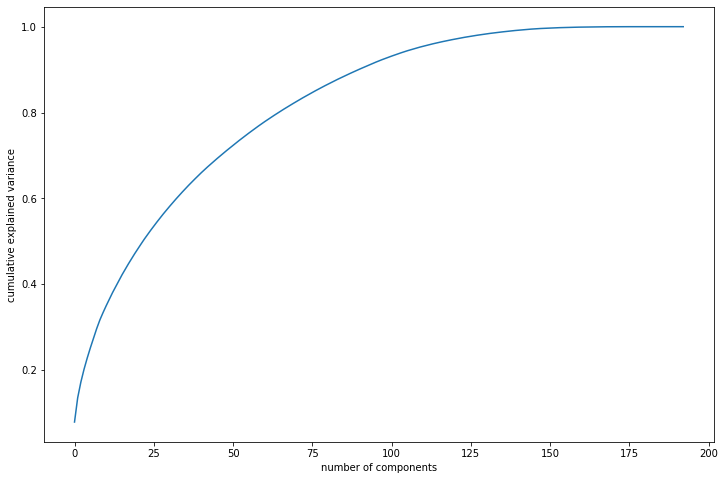

In [134]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [135]:
# Will take the most important 54 features

pca_final = PCA(n_components =54 )
df_train_pca = pca_final.fit_transform(X_train)
df_train_pca.shape

(41280, 54)

In [136]:
#Applying selected components to the test data
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(13760, 54)

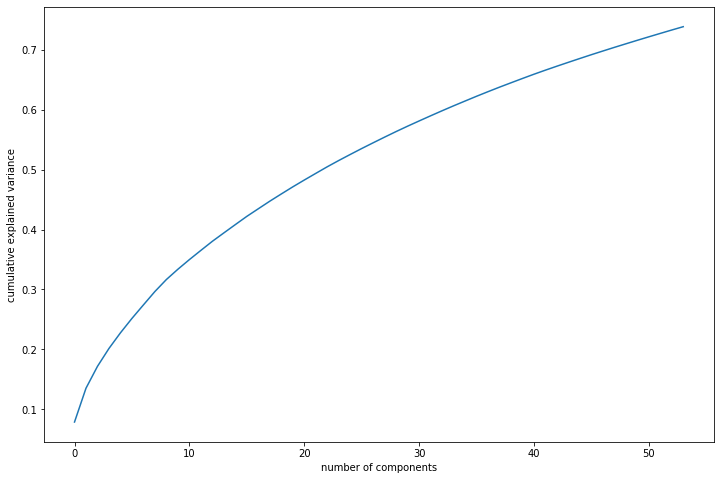

In [137]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca_final.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

With 54 features, almost 72% of the variance is explained

### Logistic Regression

Lets start with Logistic Regression with default parameters

In [138]:
learner_pca = LogisticRegression()
model_pca = learner_pca.fit(df_train_pca,y_train)

In [139]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(roc_auc_score(y_test, pred_probs_test))

'0.9'

- We were able to achieve 90% Area under the curve on the test set

Let's build couple of more models with different number of components. Let's see if the results changes

In [140]:
def get_accuracy(y_val , y_pred_val , dataset_type = "Default"):
    
    print(" Dataset type is : ", dataset_type)
    
    print("\n Accuracy Score     : ",round(accuracy_score(y_val, y_pred_val), 4) * 100)
    
    print("\n precision_accuracy : ",round(precision_score(y_val, y_pred_val), 4) * 100)
 
    print("\n recall_accuracy    : ",round(recall_score(y_val, y_pred_val), 4) * 100)
    
    print("\n roc_auc_accuracy   : ",round(roc_auc_score(y_val, y_pred_val), 4) * 100)
    
    print("\n f1_score_accuracy  : ",round(f1_score(y_val, y_pred_val), 4) * 100)
    
    print("\n explained_variance  : ",round(explained_variance_score(y_val, y_pred_val), 4) * 100)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
    
    print("\n Confusion Matrix TN : ", tn, " FP : ", fp, " FN : ", fn, " TP : ", tp)

In [141]:
y_pred_pca = model_pca.predict(df_test_pca)
get_accuracy(y_test , y_pred_pca , dataset_type = "Telecom_DF_Using_PCA_54_features")

 Dataset type is :  Telecom_DF_Using_PCA_54_features

 Accuracy Score     :  83.85000000000001

 precision_accuracy :  82.71

 recall_accuracy    :  85.87

 roc_auc_accuracy   :  83.84

 f1_score_accuracy  :  84.26

 explained_variance  :  35.55

 Confusion Matrix TN :  5590  FP :  1243  FN :  979  TP :  5948


In [142]:
pca_last1 = PCA(n_components=48)
df_train_pca1 = pca_last1.fit_transform(X_train)
df_test_pca1 = pca_last1.transform(X_test)
df_test_pca1.shape

(13760, 48)

In [143]:
#training the regression model
learner_pca1 = LogisticRegression()
model_pca1 = learner_pca1.fit(df_train_pca1,y_train)
#Making prediction on the test data
pred_probs_test1 = model_pca1.predict_proba(df_test_pca1)[:,1]
"{:2.2f}".format(roc_auc_score(y_test, pred_probs_test1))

'0.90'

With 48 features, we get an ROC AUC Score of 90%

In [144]:
y_pred_pca1 = model_pca1.predict(df_test_pca1)
get_accuracy(y_test , y_pred_pca1 , dataset_type = "Telecom_DF_Using_PCA_48_Features")

 Dataset type is :  Telecom_DF_Using_PCA_48_Features

 Accuracy Score     :  83.6

 precision_accuracy :  82.34

 recall_accuracy    :  85.82

 roc_auc_accuracy   :  83.58

 f1_score_accuracy  :  84.05

 explained_variance  :  34.57

 Confusion Matrix TN :  5558  FP :  1275  FN :  982  TP :  5945


In [145]:
pca_last2 = PCA(n_components=15)
df_train_pca2 = pca_last2.fit_transform(X_train)
df_test_pca2 = pca_last2.transform(X_test)
df_test_pca2.shape

(13760, 15)

In [146]:
#training the regression model
learner_pca2 = LogisticRegression()
model_pca2 = learner_pca2.fit(df_train_pca2,y_train)
#Making prediction on the test data
pred_probs_test2 = model_pca2.predict_proba(df_test_pca2)[:,1]
"{:2.2f}".format(roc_auc_score(y_test, pred_probs_test2))

'0.89'

With 15 features, we get an ROC AUC Score of 89%

In [147]:
y_pred_pca2 = model_pca2.predict(df_test_pca2)
get_accuracy(y_test , y_pred_pca2 , dataset_type = "Telecom_DF_Using_PCA_15_Features")

 Dataset type is :  Telecom_DF_Using_PCA_15_Features

 Accuracy Score     :  82.25

 precision_accuracy :  80.80000000000001

 recall_accuracy    :  84.91

 roc_auc_accuracy   :  82.23

 f1_score_accuracy  :  82.8

 explained_variance  :  29.24

 Confusion Matrix TN :  5435  FP :  1398  FN :  1045  TP :  5882


## Choice of Evaluation Metric

Choosing a metric is one of the key criteria for our analysis, as the dataset is imbalanced one

*Source: Wikipedia*

**Accuracy = correct predictions / total predictions = (TP + TN)/ (all)**
For a data set which is balanced, this might make a good measure. For an imbalanced dataset like the current one, where the negative class is heavier, this measure may show a high accuracy but fail to serve the purpose of the modeling exercise. We need to be able to predict non-churn i.e.; positive outcomes correctly to help business. So Accuracy may not be the best measure here.

**Recall(sensitivity) = ability to identify Positives as true =  TP/(TP + FN)**
Considering that we wish to clearly identify customers who might churn vs non-churn, recall as a metric with its ability to identify true positives might be more apt. But this does not capture models ability to mis-classify negative class as positive i.e.; False positive rate. So, if we choose a model purely based on recall, we might be blind sighted by a huge number of false positive.

**Precision = TP/ (TP + FP) = Positive predictive value:**
It is important to not only understand the rate of identifying positives as true but also identify False positives. If business is to make a decision on marketing spend to retain customers to all positive output of the model, it becomes important that the false positive rate should not be too high. So Precision as a metric - which provides the rate of true positive /total predicted positives is an apt metric to look at here.

**F Score = 2 * Precision * Recall/ (Precision * Recall):**
Fscore is the harmonic mean of Precision and Recall and provides the ability to balance the need between having a better true positive rate and not too high a false positive rate. 

**Area under the Curve:**

AUC or in the classification world – AUC ROC – Area under the curve for  Receiver Operating Characteristic curve is generally used to compare two different models. It used two metrics from the confusion matrix the true positive rate and false positive rate.

**True positive rate (TPR), recall** as described above is proportion of positive data points correctly identified as positive by the model
**False positive rate (FPR)**, which is defined as FP/(FP+TN) is all the negative data points that are mistakenly identified as positive as a proportion of all negative data points. 

The TPR and FPR metrics are calculated for several threshold values and a curve is plotted with these. The resulting curve is called ROC. AUC is the computation of the area under ROC curve. For a model selection, we always look for maximizing the AUC for the classifier. As this value is comparable across models.

In [151]:
from sklearn.metrics import auc

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6833
           1       0.83      0.86      0.84      6927

    accuracy                           0.84     13760
   macro avg       0.84      0.84      0.84     13760
weighted avg       0.84      0.84      0.84     13760

Accuracy for the test dataset 83.9%
ROC for the test dataset 83.8%


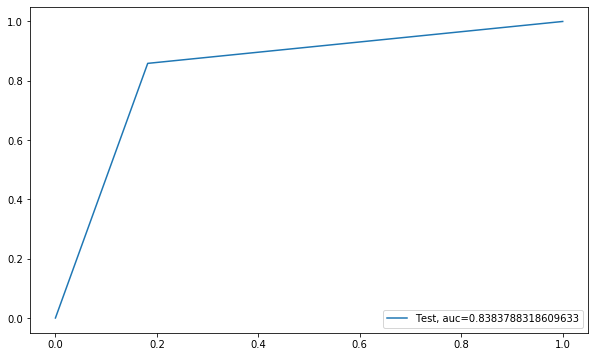

In [161]:
predictions = model_pca.predict(df_test_pca)
prediction_probs = model_pca.predict_proba(df_test_pca)[:,1]
print(classification_report(y_test, predictions))


accuracy = accuracy_score(y_test, predictions)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)


print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

### Logistic Regression - with penalty and balanced class weights

In [162]:
# Use class_weight = 'balanced' for handling imbalance data
logmodel_CW_dict = LogisticRegression(class_weight='balanced',penalty='l2',random_state=10000,solver='newton-cg',C=1,n_jobs=-1)
logmodel_CW_dict.fit(df_train_pca,y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=10000, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6833
           1       0.83      0.86      0.84      6927

    accuracy                           0.84     13760
   macro avg       0.84      0.84      0.84     13760
weighted avg       0.84      0.84      0.84     13760

Accuracy for the test dataset 83.8%
ROC for the test dataset 83.8%


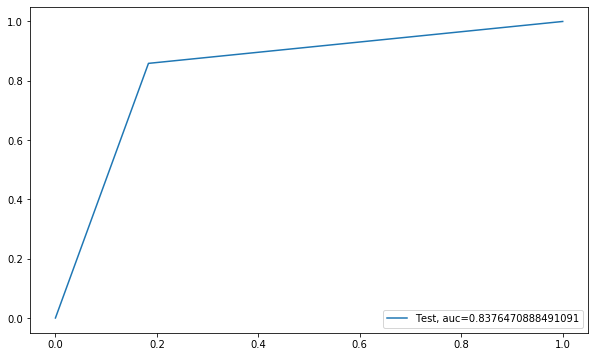

In [163]:
predictions = logmodel_CW_dict.predict(df_test_pca)
prediction_probs = logmodel_CW_dict.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, predictions))

accuracy = accuracy_score(y_test, predictions)

print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

In [ ]:
get_accuracy(y_test, predictions, "Logistic Regression - with penalty and balanced class weights")

We can see that the ROC for Test Data using Logistic Regression with Balanced class weights has improved 83.8%

### Create Stratefied Kfold Samples

In [165]:
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [166]:
searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1)

In [167]:
searchCV.fit(df_train_pca,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    5.9s finished


LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=4, random_state=9999, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=777, refit=True,
                     scoring='roc_auc', solver='newton-cg', tol=1, verbose=2)

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      6833
           1       0.83      0.86      0.84      6927

    accuracy                           0.84     13760
   macro avg       0.84      0.84      0.84     13760
weighted avg       0.84      0.84      0.84     13760

Accuracy for the test dataset 83.9%
ROC for the test dataset 90.2%


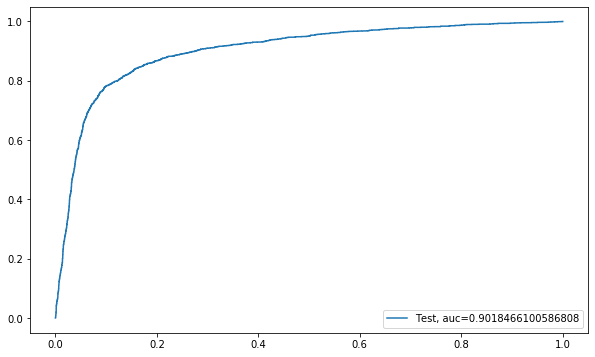

In [170]:
#train data
preds_L2Search = searchCV.predict(df_test_pca)

preds_L2Search_probs = searchCV.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, preds_L2Search_probs)
roc_auc = auc(fpr, tpr)


print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

So, for Logistic Regression, with stratified K-fold we can get better scores than balanced class option without increasing the dataset size

In [173]:
get_accuracy(y_test, preds_L2Search, "LogisticRegressionCV_Stratefied_Kfold")

 Dataset type is :  LogisticRegressionCV_Stratefied_Kfold

 Accuracy Score     :  83.85000000000001

 precision_accuracy :  82.71

 recall_accuracy    :  85.87

 roc_auc_accuracy   :  83.84

 f1_score_accuracy  :  84.26

 explained_variance  :  35.55

 Confusion Matrix TN :  5590  FP :  1243  FN :  979  TP :  5948


## Random Classifier

In [172]:
RFC_balanced = RandomForestClassifier()
TrainedRFC= RFC_balanced.fit(df_train_pca,y_train)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      6833
           1       0.97      1.00      0.99      6927

    accuracy                           0.99     13760
   macro avg       0.99      0.99      0.99     13760
weighted avg       0.99      0.99      0.99     13760

Accuracy for the test dataset 98.6%
ROC for the test dataset 99.8%


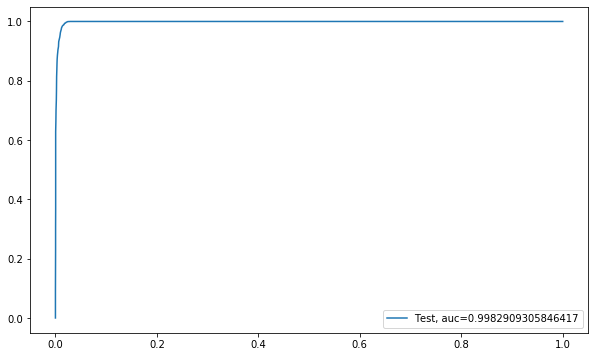

In [174]:
preds_RFC=TrainedRFC.predict(df_test_pca)
preds_probs_RFC=TrainedRFC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, preds_probs_RFC)
roc_auc = auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, Random Forest Classifier gives an ROC Score of 99.8% and accuracy of 98.6%

In [175]:
get_accuracy(y_test, preds_RFC, "Random Classifier")

 Dataset type is :  Random Classifier

 Accuracy Score     :  98.58

 precision_accuracy :  97.26

 recall_accuracy    :  100.0

 roc_auc_accuracy   :  98.57000000000001

 f1_score_accuracy  :  98.61

 explained_variance  :  94.41000000000001

 Confusion Matrix TN :  6638  FP :  195  FN :  0  TP :  6927


## Hyper Tuning Random Forest

In [ ]:
stime = time.clock()

param_grid = {
    'max_depth': [15,20,30],
    'min_samples_leaf': range(1, 10, 5),
    'min_samples_split': range(1,10, 5),
    'n_estimators': [200,300,400], 
    'max_features': [10,15]
}
RFC_balanced2 = RandomForestClassifier()

gridF = GridSearchCV(RFC_balanced2, param_grid, cv = 3, verbose = 1, n_jobs = -1,scoring="roc_auc")

bestF = gridF.fit(df_train_pca,y_train)
etime = time.clock()
print(etime - stime)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.2min


### Gradient boosting

In [ ]:
GBC = GradientBoostingClassifier()
GBC.fit(df_train_pca,y_train)

In [ ]:
preds_GBC = GBC.predict(df_test_pca)
preds_probs_GBC = GBC.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC))
accuracy = accuracy_score(y_test, preds_GBC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy))

fpr, tpr, threshold = roc_curve(y_test, preds_probs_GBC)
roc_auc = auc(fpr, tpr)


print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, Gradient Boost Classifier gives an ROC Score and accuracy 

In [ ]:
get_accuracy(y_test, preds_GBC, "Gradient boosting")

### Gradient Boosting with Hyperparameter tuning

In [ ]:
param_test = {'n_estimators':range(200,500,100), 'max_depth':range(5,8,1), 'min_samples_leaf': range(10,100,20)}

gsearch1 = GridSearchCV(
    estimator = GradientBoostingClassifier(
        learning_rate=0.05,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.1,
        random_state=9999,verbose = 2,), param_grid = param_test, scoring='roc_auc',n_jobs=-1,iid=False, cv=None,verbose=2)


In [ ]:
gsearch1.fit(df_train_pca,y_train)

In [ ]:
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
preds_GBC_HT = gsearch1.predict(df_test_pca)
preds_GBC_probs_HT = gsearch1.predict_proba(df_test_pca)[:,1]

print(classification_report(y_test, preds_GBC_HT))
accuracy = accuracy_score(y_test, preds_GBC_HT)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, preds_GBC_probs_HT)
roc_auc = auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, Gradient Boost Classifier gives an ROC Score and accuracy

In [ ]:
get_accuracy(y_test, preds_GBC_HT, "Gradient boosting with Hyperparameter tuning")

### SVM using Non-linear kernal

In [ ]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

In [ ]:
# predict
predictions = svm_rbf.predict(X_test)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, SVM with rbf kernel gives an ROC Score and accuracy 

In [ ]:
get_accuracy(y_test, predictions, "SVM using Non-linear kernal")

### SVM using Linear kernal

In [ ]:
# linear kernel with other hyperparameters kept to default 
svm_linear = SVC(kernel='linear')
svm_linear.fit(df_train_pca, y_train)

In [ ]:
# predict
predictions = svm_linear.predict(df_test_pca)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, SVM with Linear kernel gives an ROC Score and accuracy

In [ ]:
get_accuracy(y_test, predictions, "SVM using linear kernal")

## Model Building

#### On original features (instead of principal components)
#### This is required to find out the most important features that affect the churn prediction

### Logistic Regression

In [ ]:
logmodel_CW_dict = LogisticRegression(penalty='l2',random_state=10000,solver='newton-cg',C=1,n_jobs=-1)
logmodel_CW_dict.fit(X_train,y_train)

In [ ]:
predictions = logmodel_CW_dict.predict(X_test)
prediction_probs = logmodel_CW_dict.predict_proba(X_test)[:,1]
print(classification_report(y_test, predictions))


accuracy = accuracy_score(y_test, predictions)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With balanced class weights, Logisctic regression on 204 features gives an ROC Score and accuracy

In [ ]:
get_accuracy(y_test, predictions , "Logistic Regression_Without_PCA")

### Create Stratefied Kfold Samples

In [ ]:
stratefied_Kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=9999)

In [ ]:
searchCV = LogisticRegressionCV(
        Cs= list(np.power(10.0, np.arange(-10, 10)))
        ,penalty='l2'
        ,scoring='roc_auc'
        ,cv=stratefied_Kfold
        ,random_state=777
        ,max_iter=100
        ,fit_intercept=True
        ,solver='newton-cg'
        ,tol=1
        ,verbose = 2
        ,n_jobs = -1)

In [ ]:
searchCV.fit(X_train,y_train)

In [ ]:
#train data
preds_L2Search = searchCV.predict(X_test)
preds_L2Search_probs = searchCV.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_L2Search))
accuracy = metrics.accuracy_score(y_test, preds_L2Search)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = metrics.roc_curve(y_test, preds_L2Search_probs)
roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With stratified K Fold technique Logisctic regression on 204 features gives an ROC Score and accuracy

In [ ]:
get_accuracy(y_test, predictions , "Logistic Regression_Without_PCA")

## Random Forest
### With Default Parameters

In [ ]:
RFC_balanced = RandomForestClassifier()
TrainedRFC= RFC_balanced.fit(X_train,y_train)

In [ ]:
RFC_balanced.get_params

In [ ]:
preds_RFC=TrainedRFC.predict(X_test)
preds_probs_RFC=TrainedRFC.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_RFC))
accuracy = accuracy_score(y_test, preds_RFC)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy) )

fpr, tpr, threshold = roc_curve(y_test, preds_probs_RFC)
roc_auc = auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, Random Forest Classifier on 204 features gives an ROC Score and accuracy 

In [ ]:
get_accuracy(y_test, preds_RFC , "Random Forest Default Parameter")

## Hyper Tuning Random Forest

In [ ]:
stime = time.clock()
param_grid = {
    'max_depth': [15,20,30],
    'min_samples_leaf': range(1, 10, 5),
    'min_samples_split': range(1,10, 5),
    'n_estimators': [200,300,400], 
    'max_features': [10,15]
}

RFC_balanced2 = RandomForestClassifier()

gridF = GridSearchCV(RFC_balanced2, param_grid, cv = 3, verbose = 1, 
                      n_jobs = -1,scoring="roc_auc")
bestF = gridF.fit(X_train,y_train)
etime = time.clock()
print((etime - stime)/60)

### SVM using Non-linear kernal

In [316]:
# rbf kernel with other hyperparameters kept to default 
svm_rbf = SVC(kernel='rbf',class_weight = 'balanced')
svm_rbf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3


Accuracy for the test dataset 66.7%

ROC for the test dataset 75.0%


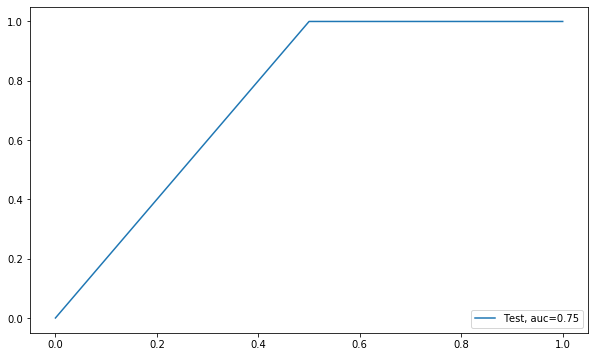

In [317]:
# predict
predictions = svm_rbf.predict(X_test)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, SVM with rbf kernel on 204 features gives an ROC Score and accuracy


In [ ]:
get_accuracy(y_test, predictions, "SVM using Non-linear kernal")

### SVM using Linear kernal

In [319]:
# linear kernel with other hyperparameters kept to default 
svm_linear = SVC(kernel='linear',class_weight = 'balanced')
svm_linear.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.50      1.00      0.67         1

    accuracy                           0.67         3
   macro avg       0.75      0.75      0.67         3
weighted avg       0.83      0.67      0.67         3


Accuracy for the test dataset 66.7%

ROC for the test dataset 75.0%


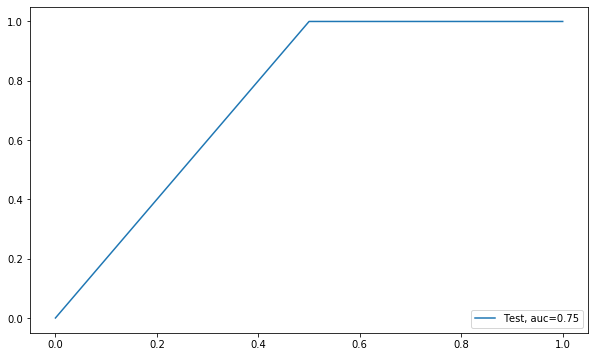

In [320]:
# predict
predictions = svm_linear.predict(X_test)
print("Classification report: ")
print(classification_report(y_test,predictions))
accuracy = accuracy_score(y_test, predictions)
print("\nAccuracy for the test dataset",'{:.1%}'.format(accuracy) )
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)
print("\nROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.legend(loc=4)
plt.show()

With default parameters, SVM with linear kernel on 204 features gives an ROC Score and accuracy

In [321]:
get_accuracy(y_test, predictions, "SVM using Linear kernal")

 Dataset type is :  SVM using Linear kernal

 Accuracy Score     :  66.67

 precision_accuracy :  50.0

 recall_accuracy    :  100.0

 roc_auc_accuracy   :  75.0

 f1_score_accuracy  :  66.67

 explained_variance  :  0.0

 Confusion Matrix TN :  1  FP :  1  FN :  0  TP :  1


## Summary about the models

- We trained different machine learning models to solve this classification problems. 
- Both with PCA and without PCA, Random Forest Classifier performed the best when compared with other models.
- The Random Forest Classifier was able to provide the same performance of the models with Balanced Class option and without balanced class option.
- The **Algorithmic Ensemble Techniques** like Gradient Boosting Algorithm was able to provide almost same performance as Random Forest Classifier
- Logistic Regression works bad with imbalanced data. When using Balanced Class option, Logistic regression works quite decent.
- Performace of SVM with Linear and Non- Linear Kernels was improved with balanced class weights option. Still the performance was lesser when compared to Logistic Regression and Random Forest.
- We considered F1-score and Area under the curve as the primary metrics for the evaluation 

In [322]:
RFCBest = RandomForestClassifier(max_depth= 30,
 max_features= 15,
 min_samples_leaf= 6,
 min_samples_split =  6,
 n_estimators= 300, class_weight = 'balanced')
TrainedRFC= RFCBest.fit(X_train,y_train)

ValueError: max_features must be in (0, n_features]

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5339
           1       0.63      0.68      0.65       652

    accuracy                           0.92      5991
   macro avg       0.80      0.81      0.81      5991
weighted avg       0.92      0.92      0.92      5991

Accuracy for the test dataset 92.2%
ROC for the test dataset 93.2%


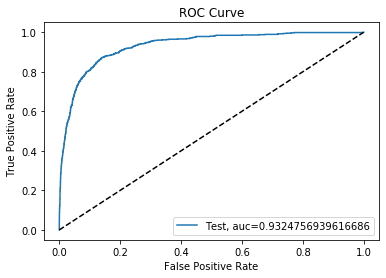

In [165]:
preds_RF = TrainedRFC.predict(X_test)
preds_probs_RF = TrainedRFC.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds_RF))
accuracy = accuracy_score(y_test, preds_RF)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy))

fpr, tpr, threshold = roc_curve(y_test, preds_probs_RF)
roc_auc = auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()
plt.legend(loc=4)
plt.show()

Hyper Tuning of Random Forest provided the best metrics out of all.
Best Params are as follows: 


    {'max_depth': 30,
     'max_features': 15,
     'min_samples_leaf': 6,
     'min_samples_split': 6,
     'n_estimators': 300}
 
 We got an accuracy on test data and ROC on test data.
 
 More metrics of this model are as below
      
            precision    recall    f1-score  support

       0       0.96      0.95      0.96      5339
       1       0.63      0.68      0.65       652

In [ ]:
get_accuracy(y_test, preds_RF, "RandomForestClassifier Hyper Parameter Tuning")

In [166]:
importances = TrainedRFC.feature_importances_
col_names =  X.columns

RF_feature_importance = pd.DataFrame(sorted(zip(importances, list(col_names)), reverse=True))
RF_feature_importance.rename(columns={0:'value', 1 :'colName'},inplace =True)
RF_feature_importF_imp=Randance.head()

NameError: name 'Randance' is not defined

##### Lets choose top 20 important features and build a Random Forest Model

In [167]:
imp_features = RF_feature_importance.head(20)

In [168]:
X_imp = telecom_df[list(imp_features.colName.unique())]
Y_imp = telecom_df['churn_flag']

In [169]:
X_imp_std = scaler.fit_transform(X_imp)
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp_std,Y_imp, train_size=0.8,test_size=0.2,random_state=111)

In [323]:
RF_imp=RandomForestClassifier(max_depth= 30,
 max_features= 15,
 min_samples_leaf= 6,
 min_samples_split =  6,
 n_estimators= 300, class_weight = 'balanced',random_state=111)
RF_imp.fit(X_imp_train, y_imp_train)

NameError: name 'X_imp_train' is not defined

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      5339
           1       0.57      0.71      0.63       652

    accuracy                           0.91      5991
   macro avg       0.76      0.82      0.79      5991
weighted avg       0.92      0.91      0.91      5991

Accuracy for the test dataset 90.9%
ROC for the test dataset 92.2%


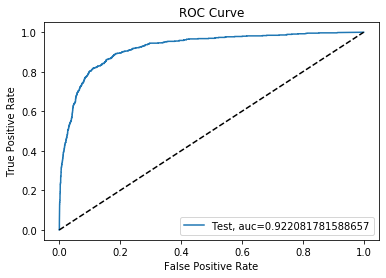

In [171]:
preds_RF = RF_imp.predict(X_imp_test)
preds_probs_RF = RF_imp.predict_proba(X_imp_test)[:,1]

print(classification_report(y_test, preds_RF))
accuracy = accuracy_score(y_test, preds_RF)
print("Accuracy for the test dataset",'{:.1%}'.format(accuracy))

fpr, tpr, threshold = roc_curve(y_test, preds_probs_RF)
roc_auc = auc(fpr, tpr)
print("ROC for the test dataset",'{:.1%}'.format(roc_auc))
plt.plot(fpr,tpr,label="Test, auc="+str(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot()
plt.legend(loc=4)
plt.show()

We train our random forest algorithm on the top 20 features that we selected above and then we evaluated the performance of our algorithm on the training and testing sets. We can see that the AUC & F1-score are pretty similar to a model trained with all 204 features which means our model is not overfitting.

In [ ]:
get_accuracy(y_test, preds_RF, "20 important features and build a Random Forest Model")

In [172]:
imp_features

,value,colName
0,0.07,loc_ic_mou_8
1,0.06,loc_og_t2m_mou_8
2,0.05,loc_ic_t2m_mou_8
3,0.04,loc_og_mou_8
4,0.04,arpu_8
5,0.04,loc_ic_t2t_mou_8
6,0.03,last_day_rch_amt_8
7,0.03,offnet_mou_8
8,0.02,date_of_last_rech_8diff7
9,0.02,max_rech_amt_8


So, we can conclude that these are the important indicators of churn

## Recommendations to Business

- From the above we can clearly infer that calls related incoming & outgoing within a circle is key for identifying churn customers 
- Calls made to other operators as well as to same operators are key for identyfing churn customers
- Average revenue per user is also a key indicator for identifying the churn, if ARPU is lesser, theen their usage of the network is reduced and the customer is going to be churned
- The day when last recharged also made an impact in identifying churm customers
- Especially the usage during the action phase when compared to good month (7th month) has reduced
- The other key factor is if the recharge amount shows a dip in the action phase is sign of churn



# <font color ='green' > Extra (XGBoost, LighGBM, CatBoost)

# <font color ='blue' > XGBClassifier

In [328]:
model_xgbc = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
class_weight = 'balanced',
 seed=27)

model_xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [329]:
y_pred_xgbc = model_xgbc.predict(X_test)
get_accuracy(y_test , y_pred_xgbc, "XGBClassifier")

 Dataset type is :  XGBClassifier

 Accuracy Score     :  33.33

 precision_accuracy :  33.33

 recall_accuracy    :  100.0

 roc_auc_accuracy   :  50.0

 f1_score_accuracy  :  50.0

 explained_variance  :  0.0

 Confusion Matrix TN :  0  FP :  2  FN :  0  TP :  1


# <font color ='blue' > LGBMClassifier

In [330]:
lg_param_test = {
    
    'gamma': [0.5, 0.25],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.07, 0.05],
    'n_estimators': [200, 100]
  
}


LGB_hyper_params = GridSearchCV(estimator = 
LGBMClassifier(learning_rate =0.1,
              nthread=4,
              seed=27), 
              param_grid = lg_param_test,
              scoring= 'accuracy',
              n_jobs=4,
              iid=False,
              verbose=10)

In [331]:
LGB_hyper_params.fit(X_train,y_train)


print(LGB_hyper_params.best_params_)




Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.4s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.5s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1690s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0174s.) Setting batch_size=4.


{'gamma': 0.5, 'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 200}


[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:   11.6s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0781s.) Setting batch_size=8.
[Parallel(n_jobs=4)]: Done  92 tasks      | elapsed:   11.8s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1116s.) Setting batch_size=16.
[Parallel(n_jobs=4)]: Done 100 out of 120 | elapsed:   11.8s remaining:    2.4s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:   11.8s finished


In [332]:
lgbclf= LGBMClassifier(gamma= 0.5, learning_rate= 0.07,max_depth= 3, n_estimators= 200)

lgbclf.fit(X_train,y_train)

y_pred_lgbclf = lgbclf.predict(X_test)
get_accuracy(y_test , y_pred_lgbclf, "LGBMClassifier")

 Dataset type is :  LGBMClassifier

 Accuracy Score     :  33.33

 precision_accuracy :  33.33

 recall_accuracy    :  100.0

 roc_auc_accuracy   :  50.0

 f1_score_accuracy  :  50.0

 explained_variance  :  0.0

 Confusion Matrix TN :  0  FP :  2  FN :  0  TP :  1


# <font color ='blue' > CatBoostClassifier

In [334]:
from catboost import CatBoostClassifier


cat_param_test = {
    'depth':[2, 3],
    'learning_rate': [0.07, 0.05],
    'n_estimators': [200, 100],
    'loss_function': ['Logloss', 'CrossEntropy', 'MultiClass'],
    'l2_leaf_reg':np.logspace(-25, -20, 3)
  
}

CAT_hyper_params = GridSearchCV(estimator = 
CatBoostClassifier(learning_rate =0.1), 
              param_grid = cat_param_test,
              scoring= 'accuracy',
              n_jobs=4,
                                
              iid=False,
              verbose=10)

In [335]:
%%time

CAT_hyper_params.fit(X_train,y_train)

print(CAT_hyper_params.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   10.0s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   16.6s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:   21.1s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:   23.0s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:   28.0s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:   31.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   33.5s
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:   36.7s
[Parallel(

0:	learn: 0.6397942	total: 48.1ms	remaining: 9.57s
1:	learn: 0.5447002	total: 48.5ms	remaining: 4.81s
2:	learn: 0.4435547	total: 48.8ms	remaining: 3.21s
3:	learn: 0.2856623	total: 49.1ms	remaining: 2.41s
4:	learn: 0.2699996	total: 49.4ms	remaining: 1.93s
5:	learn: 0.2234125	total: 49.7ms	remaining: 1.6s
6:	learn: 0.1636003	total: 49.9ms	remaining: 1.38s
7:	learn: 0.1194008	total: 50.2ms	remaining: 1.2s
8:	learn: 0.0829279	total: 50.4ms	remaining: 1.07s
9:	learn: 0.0603138	total: 50.8ms	remaining: 965ms
10:	learn: 0.0489586	total: 51.1ms	remaining: 877ms
11:	learn: 0.0368721	total: 51.4ms	remaining: 805ms
12:	learn: 0.0278952	total: 51.8ms	remaining: 745ms
13:	learn: 0.0210228	total: 52.3ms	remaining: 694ms
14:	learn: 0.0165424	total: 52.6ms	remaining: 649ms
15:	learn: 0.0119687	total: 53ms	remaining: 610ms
16:	learn: 0.0112977	total: 53.3ms	remaining: 574ms
17:	learn: 0.0075743	total: 53.6ms	remaining: 542ms
18:	learn: 0.0051121	total: 53.9ms	remaining: 513ms
19:	learn: 0.0034302	total

{'depth': 2, 'l2_leaf_reg': 1e-25, 'learning_rate': 0.07, 'loss_function': 'Logloss', 'n_estimators': 200}
CPU times: user 3.3 s, sys: 159 ms, total: 3.46 s
Wall time: 1min 17s


In [336]:
catclf= CatBoostClassifier(depth= 3,l2_leaf_reg= 1e-25,learning_rate= 0.07,loss_function= 'Logloss',n_estimators= 200)

catclf.fit(X_train,y_train)


0:	learn: 0.6118619	total: 606us	remaining: 121ms
1:	learn: 0.4572269	total: 2.15ms	remaining: 213ms
2:	learn: 0.3448424	total: 3.48ms	remaining: 228ms
3:	learn: 0.2471303	total: 4.77ms	remaining: 234ms
4:	learn: 0.1560880	total: 6.07ms	remaining: 237ms
5:	learn: 0.1095051	total: 7.37ms	remaining: 238ms
6:	learn: 0.0948123	total: 8.32ms	remaining: 230ms
7:	learn: 0.0847724	total: 9.61ms	remaining: 231ms
8:	learn: 0.0598625	total: 10.9ms	remaining: 230ms
9:	learn: 0.0436943	total: 12ms	remaining: 229ms
10:	learn: 0.0371249	total: 13.3ms	remaining: 228ms
11:	learn: 0.0285812	total: 14.4ms	remaining: 226ms
12:	learn: 0.0143057	total: 15.2ms	remaining: 218ms
13:	learn: 0.0092557	total: 15.8ms	remaining: 210ms
14:	learn: 0.0064513	total: 16.5ms	remaining: 204ms
15:	learn: 0.0032097	total: 17.2ms	remaining: 198ms
16:	learn: 0.0023963	total: 18ms	remaining: 193ms
17:	learn: 0.0011907	total: 18.7ms	remaining: 189ms
18:	learn: 0.0005915	total: 19.4ms	remaining: 185ms
19:	learn: 0.0003151	total:

In [337]:
y_pred_catclf = catclf.predict(X_test)
get_accuracy(y_test , y_pred_catclf, "CatBoostClassifier")

 Dataset type is :  CatBoostClassifier

 Accuracy Score     :  66.67

 precision_accuracy :  50.0

 recall_accuracy    :  100.0

 roc_auc_accuracy   :  75.0

 f1_score_accuracy  :  66.67

 explained_variance  :  0.0

 Confusion Matrix TN :  1  FP :  1  FN :  0  TP :  1


In [377]:
rows=[]

def addRandomStateForAlgorithm(x,y,names,algorithms,columns_name,random_state_list):    
    for j in range(len(algorithms)):
        model = algorithms[j]
        for i in random_state_list:
            
            x_train, x_test , y_train , y_test = train_test_split(x ,y , test_size = 0.30 , random_state = i)
            
            model.fit(x_train,y_train)
            
            y_pred_train = model.predict(x_train)
            y_pred = model.predict(x_test)
            
            train_acc = accuracy_score(y_train, y_pred_train)
            train_acc = round(train_acc, 4) * 100
            
            test_acc = accuracy_score(y_test, y_pred)
            test_acc = round(test_acc, 4) * 100
            
            roc_auc_score_acc = roc_auc_score(y_test, y_pred)
            roc_auc_score_acc = round(roc_auc_score_acc, 4) * 100
            
            row = [names[j],   i,   train_acc, test_acc, roc_auc_score_acc]
    
            rows.append(row)
            
    models_df = pd.DataFrame(rows) 
    
    models_df.columns = columns_name
    print(models_df)
    

In [378]:
names = [ "LightGBM", "RF", "XGBoost" , "SVM", "LogisticRegression", "DTClassifier", "CatBoostClassifier"]

algorithms = [ LGBMClassifier(  ), RandomForestClassifier(), XGBClassifier(), SVC() ,
              LogisticRegression(), DecisionTreeClassifier(), CatBoostClassifier()]


columns_name = ["Model",    "Random_state",   'Train_acc',     "Test_acc" , "roc_auc_acc"]

random_state_list_up_to_3 = [1,2,3]

addRandomStateForAlgorithm(X,Y,names,algorithms,columns_name,random_state_list_up_to_3)

Learning rate set to 0.015948
0:	learn: 0.6831688	total: 6.97ms	remaining: 6.96s
1:	learn: 0.6735146	total: 12.7ms	remaining: 6.36s
2:	learn: 0.6633337	total: 18.3ms	remaining: 6.08s
3:	learn: 0.6522350	total: 23.9ms	remaining: 5.96s
4:	learn: 0.6436423	total: 29.7ms	remaining: 5.9s
5:	learn: 0.6360403	total: 35ms	remaining: 5.79s
6:	learn: 0.6272800	total: 40.8ms	remaining: 5.79s
7:	learn: 0.6199105	total: 46.5ms	remaining: 5.77s
8:	learn: 0.6116355	total: 52.7ms	remaining: 5.8s
9:	learn: 0.6042066	total: 58.1ms	remaining: 5.75s
10:	learn: 0.5975264	total: 63.7ms	remaining: 5.72s
11:	learn: 0.5913934	total: 69.5ms	remaining: 5.72s
12:	learn: 0.5843726	total: 75.4ms	remaining: 5.72s
13:	learn: 0.5767733	total: 81.1ms	remaining: 5.71s
14:	learn: 0.5706907	total: 86.9ms	remaining: 5.7s
15:	learn: 0.5652824	total: 92.6ms	remaining: 5.69s
16:	learn: 0.5588662	total: 98.3ms	remaining: 5.68s
17:	learn: 0.5535710	total: 104ms	remaining: 5.67s
18:	learn: 0.5473898	total: 110ms	remaining: 5.66s

163:	learn: 0.3251578	total: 582ms	remaining: 2.97s
164:	learn: 0.3245598	total: 585ms	remaining: 2.96s
165:	learn: 0.3240716	total: 587ms	remaining: 2.95s
166:	learn: 0.3231808	total: 590ms	remaining: 2.94s
167:	learn: 0.3228683	total: 593ms	remaining: 2.93s
168:	learn: 0.3224174	total: 595ms	remaining: 2.93s
169:	learn: 0.3220485	total: 598ms	remaining: 2.92s
170:	learn: 0.3218047	total: 601ms	remaining: 2.91s
171:	learn: 0.3211278	total: 603ms	remaining: 2.9s
172:	learn: 0.3204796	total: 606ms	remaining: 2.9s
173:	learn: 0.3201521	total: 608ms	remaining: 2.89s
174:	learn: 0.3194759	total: 611ms	remaining: 2.88s
175:	learn: 0.3188244	total: 614ms	remaining: 2.87s
176:	learn: 0.3180839	total: 616ms	remaining: 2.87s
177:	learn: 0.3175094	total: 619ms	remaining: 2.86s
178:	learn: 0.3171847	total: 622ms	remaining: 2.85s
179:	learn: 0.3167471	total: 624ms	remaining: 2.84s
180:	learn: 0.3160926	total: 627ms	remaining: 2.83s
181:	learn: 0.3155224	total: 629ms	remaining: 2.83s
182:	learn: 0.

354:	learn: 0.2521186	total: 1.16s	remaining: 2.11s
355:	learn: 0.2518233	total: 1.17s	remaining: 2.11s
356:	learn: 0.2514961	total: 1.17s	remaining: 2.11s
357:	learn: 0.2512514	total: 1.18s	remaining: 2.11s
358:	learn: 0.2509200	total: 1.18s	remaining: 2.1s
359:	learn: 0.2505766	total: 1.18s	remaining: 2.1s
360:	learn: 0.2503209	total: 1.19s	remaining: 2.11s
361:	learn: 0.2498868	total: 1.2s	remaining: 2.11s
362:	learn: 0.2494236	total: 1.2s	remaining: 2.1s
363:	learn: 0.2492210	total: 1.2s	remaining: 2.1s
364:	learn: 0.2488910	total: 1.21s	remaining: 2.1s
365:	learn: 0.2485904	total: 1.21s	remaining: 2.09s
366:	learn: 0.2483350	total: 1.21s	remaining: 2.1s
367:	learn: 0.2478647	total: 1.22s	remaining: 2.09s
368:	learn: 0.2474779	total: 1.22s	remaining: 2.09s
369:	learn: 0.2469737	total: 1.23s	remaining: 2.09s
370:	learn: 0.2467068	total: 1.23s	remaining: 2.08s
371:	learn: 0.2463458	total: 1.23s	remaining: 2.08s
372:	learn: 0.2458982	total: 1.23s	remaining: 2.07s
373:	learn: 0.2456186

543:	learn: 0.2007210	total: 1.74s	remaining: 1.46s
544:	learn: 0.2005089	total: 1.75s	remaining: 1.46s
545:	learn: 0.2001599	total: 1.75s	remaining: 1.46s
546:	learn: 0.1999151	total: 1.76s	remaining: 1.46s
547:	learn: 0.1997272	total: 1.76s	remaining: 1.45s
548:	learn: 0.1995228	total: 1.77s	remaining: 1.45s
549:	learn: 0.1992991	total: 1.77s	remaining: 1.45s
550:	learn: 0.1991262	total: 1.77s	remaining: 1.45s
551:	learn: 0.1987905	total: 1.78s	remaining: 1.44s
552:	learn: 0.1984863	total: 1.78s	remaining: 1.44s
553:	learn: 0.1983268	total: 1.78s	remaining: 1.43s
554:	learn: 0.1981582	total: 1.78s	remaining: 1.43s
555:	learn: 0.1979629	total: 1.79s	remaining: 1.43s
556:	learn: 0.1978348	total: 1.79s	remaining: 1.42s
557:	learn: 0.1978153	total: 1.79s	remaining: 1.42s
558:	learn: 0.1975280	total: 1.8s	remaining: 1.42s
559:	learn: 0.1973660	total: 1.81s	remaining: 1.42s
560:	learn: 0.1970365	total: 1.81s	remaining: 1.42s
561:	learn: 0.1966942	total: 1.82s	remaining: 1.42s
562:	learn: 0

706:	learn: 0.1669778	total: 2.48s	remaining: 1.03s
707:	learn: 0.1668532	total: 2.49s	remaining: 1.02s
708:	learn: 0.1666557	total: 2.49s	remaining: 1.02s
709:	learn: 0.1663954	total: 2.5s	remaining: 1.02s
710:	learn: 0.1663071	total: 2.5s	remaining: 1.02s
711:	learn: 0.1660509	total: 2.51s	remaining: 1.01s
712:	learn: 0.1658600	total: 2.51s	remaining: 1.01s
713:	learn: 0.1656613	total: 2.51s	remaining: 1.01s
714:	learn: 0.1656357	total: 2.52s	remaining: 1s
715:	learn: 0.1653709	total: 2.52s	remaining: 1000ms
716:	learn: 0.1651355	total: 2.52s	remaining: 996ms
717:	learn: 0.1650334	total: 2.53s	remaining: 993ms
718:	learn: 0.1648981	total: 2.53s	remaining: 989ms
719:	learn: 0.1648858	total: 2.53s	remaining: 986ms
720:	learn: 0.1647958	total: 2.54s	remaining: 982ms
721:	learn: 0.1645515	total: 2.54s	remaining: 979ms
722:	learn: 0.1644279	total: 2.54s	remaining: 975ms
723:	learn: 0.1642403	total: 2.55s	remaining: 972ms
724:	learn: 0.1641081	total: 2.55s	remaining: 968ms
725:	learn: 0.16

910:	learn: 0.1378290	total: 3.25s	remaining: 318ms
911:	learn: 0.1378184	total: 3.26s	remaining: 314ms
912:	learn: 0.1377297	total: 3.26s	remaining: 311ms
913:	learn: 0.1376411	total: 3.26s	remaining: 307ms
914:	learn: 0.1374909	total: 3.26s	remaining: 303ms
915:	learn: 0.1372899	total: 3.27s	remaining: 299ms
916:	learn: 0.1371606	total: 3.27s	remaining: 296ms
917:	learn: 0.1370743	total: 3.27s	remaining: 292ms
918:	learn: 0.1369794	total: 3.27s	remaining: 289ms
919:	learn: 0.1367593	total: 3.28s	remaining: 285ms
920:	learn: 0.1366336	total: 3.28s	remaining: 281ms
921:	learn: 0.1365077	total: 3.28s	remaining: 278ms
922:	learn: 0.1364970	total: 3.28s	remaining: 274ms
923:	learn: 0.1363821	total: 3.29s	remaining: 270ms
924:	learn: 0.1362934	total: 3.29s	remaining: 267ms
925:	learn: 0.1361077	total: 3.29s	remaining: 263ms
926:	learn: 0.1359994	total: 3.29s	remaining: 260ms
927:	learn: 0.1358605	total: 3.3s	remaining: 256ms
928:	learn: 0.1357941	total: 3.3s	remaining: 252ms
929:	learn: 0.

69:	learn: 0.4240455	total: 401ms	remaining: 5.32s
70:	learn: 0.4224617	total: 404ms	remaining: 5.28s
71:	learn: 0.4211214	total: 408ms	remaining: 5.26s
72:	learn: 0.4197212	total: 418ms	remaining: 5.31s
73:	learn: 0.4182003	total: 421ms	remaining: 5.27s
74:	learn: 0.4170596	total: 425ms	remaining: 5.24s
75:	learn: 0.4155152	total: 428ms	remaining: 5.2s
76:	learn: 0.4143614	total: 431ms	remaining: 5.16s
77:	learn: 0.4131978	total: 434ms	remaining: 5.13s
78:	learn: 0.4120246	total: 437ms	remaining: 5.09s
79:	learn: 0.4111596	total: 440ms	remaining: 5.05s
80:	learn: 0.4098422	total: 442ms	remaining: 5.02s
81:	learn: 0.4087186	total: 451ms	remaining: 5.04s
82:	learn: 0.4075641	total: 455ms	remaining: 5.03s
83:	learn: 0.4069070	total: 466ms	remaining: 5.08s
84:	learn: 0.4058652	total: 469ms	remaining: 5.05s
85:	learn: 0.4046981	total: 473ms	remaining: 5.03s
86:	learn: 0.4037616	total: 480ms	remaining: 5.03s
87:	learn: 0.4030013	total: 484ms	remaining: 5.01s
88:	learn: 0.4020704	total: 488m

240:	learn: 0.3065063	total: 980ms	remaining: 3.08s
241:	learn: 0.3060163	total: 986ms	remaining: 3.09s
242:	learn: 0.3053503	total: 989ms	remaining: 3.08s
243:	learn: 0.3049862	total: 992ms	remaining: 3.07s
244:	learn: 0.3045487	total: 994ms	remaining: 3.06s
245:	learn: 0.3040799	total: 997ms	remaining: 3.06s
246:	learn: 0.3037407	total: 1000ms	remaining: 3.05s
247:	learn: 0.3034502	total: 1s	remaining: 3.04s
248:	learn: 0.3031181	total: 1s	remaining: 3.03s
249:	learn: 0.3027924	total: 1.01s	remaining: 3.02s
250:	learn: 0.3024194	total: 1.01s	remaining: 3.02s
251:	learn: 0.3019051	total: 1.01s	remaining: 3.01s
252:	learn: 0.3016806	total: 1.02s	remaining: 3s
253:	learn: 0.3013867	total: 1.02s	remaining: 3s
254:	learn: 0.3008153	total: 1.03s	remaining: 3s
255:	learn: 0.3004937	total: 1.03s	remaining: 3s
256:	learn: 0.3001192	total: 1.03s	remaining: 2.98s
257:	learn: 0.2994595	total: 1.03s	remaining: 2.98s
258:	learn: 0.2990386	total: 1.04s	remaining: 2.97s
259:	learn: 0.2984783	total: 

417:	learn: 0.2449548	total: 1.55s	remaining: 2.16s
418:	learn: 0.2444932	total: 1.56s	remaining: 2.16s
419:	learn: 0.2441243	total: 1.56s	remaining: 2.15s
420:	learn: 0.2438814	total: 1.56s	remaining: 2.15s
421:	learn: 0.2436533	total: 1.57s	remaining: 2.15s
422:	learn: 0.2433403	total: 1.57s	remaining: 2.14s
423:	learn: 0.2431384	total: 1.57s	remaining: 2.13s
424:	learn: 0.2428402	total: 1.57s	remaining: 2.13s
425:	learn: 0.2427068	total: 1.58s	remaining: 2.12s
426:	learn: 0.2425053	total: 1.58s	remaining: 2.12s
427:	learn: 0.2422996	total: 1.58s	remaining: 2.11s
428:	learn: 0.2421181	total: 1.58s	remaining: 2.11s
429:	learn: 0.2418936	total: 1.59s	remaining: 2.1s
430:	learn: 0.2415600	total: 1.59s	remaining: 2.1s
431:	learn: 0.2414127	total: 1.6s	remaining: 2.1s
432:	learn: 0.2411263	total: 1.6s	remaining: 2.09s
433:	learn: 0.2408384	total: 1.6s	remaining: 2.09s
434:	learn: 0.2404820	total: 1.6s	remaining: 2.08s
435:	learn: 0.2401192	total: 1.6s	remaining: 2.08s
436:	learn: 0.239802

640:	learn: 0.1856298	total: 2.13s	remaining: 1.19s
641:	learn: 0.1854771	total: 2.13s	remaining: 1.19s
642:	learn: 0.1852003	total: 2.13s	remaining: 1.19s
643:	learn: 0.1849887	total: 2.14s	remaining: 1.18s
644:	learn: 0.1849211	total: 2.14s	remaining: 1.18s
645:	learn: 0.1846208	total: 2.14s	remaining: 1.17s
646:	learn: 0.1845520	total: 2.15s	remaining: 1.17s
647:	learn: 0.1843354	total: 2.15s	remaining: 1.17s
648:	learn: 0.1841522	total: 2.15s	remaining: 1.16s
649:	learn: 0.1838097	total: 2.15s	remaining: 1.16s
650:	learn: 0.1835804	total: 2.16s	remaining: 1.16s
651:	learn: 0.1834076	total: 2.16s	remaining: 1.15s
652:	learn: 0.1831125	total: 2.16s	remaining: 1.15s
653:	learn: 0.1829909	total: 2.17s	remaining: 1.15s
654:	learn: 0.1826023	total: 2.18s	remaining: 1.15s
655:	learn: 0.1823318	total: 2.19s	remaining: 1.15s
656:	learn: 0.1822661	total: 2.19s	remaining: 1.14s
657:	learn: 0.1819954	total: 2.19s	remaining: 1.14s
658:	learn: 0.1817185	total: 2.19s	remaining: 1.14s
659:	learn: 

857:	learn: 0.1474312	total: 2.71s	remaining: 448ms
858:	learn: 0.1472436	total: 2.71s	remaining: 445ms
859:	learn: 0.1470855	total: 2.71s	remaining: 442ms
860:	learn: 0.1469944	total: 2.71s	remaining: 438ms
861:	learn: 0.1469413	total: 2.72s	remaining: 435ms
862:	learn: 0.1468031	total: 2.72s	remaining: 432ms
863:	learn: 0.1466018	total: 2.72s	remaining: 429ms
864:	learn: 0.1464046	total: 2.73s	remaining: 426ms
865:	learn: 0.1462278	total: 2.73s	remaining: 423ms
866:	learn: 0.1460929	total: 2.73s	remaining: 419ms
867:	learn: 0.1459204	total: 2.74s	remaining: 416ms
868:	learn: 0.1457394	total: 2.74s	remaining: 413ms
869:	learn: 0.1456355	total: 2.74s	remaining: 410ms
870:	learn: 0.1454458	total: 2.75s	remaining: 407ms
871:	learn: 0.1453095	total: 2.75s	remaining: 404ms
872:	learn: 0.1451915	total: 2.76s	remaining: 401ms
873:	learn: 0.1449816	total: 2.76s	remaining: 398ms
874:	learn: 0.1448064	total: 2.76s	remaining: 394ms
875:	learn: 0.1447065	total: 2.76s	remaining: 391ms
876:	learn: 

15:	learn: 0.5697823	total: 218ms	remaining: 13.4s
16:	learn: 0.5634924	total: 231ms	remaining: 13.3s
17:	learn: 0.5591494	total: 244ms	remaining: 13.3s
18:	learn: 0.5537186	total: 250ms	remaining: 12.9s
19:	learn: 0.5481165	total: 254ms	remaining: 12.5s
20:	learn: 0.5431821	total: 257ms	remaining: 12s
21:	learn: 0.5373120	total: 260ms	remaining: 11.6s
22:	learn: 0.5319671	total: 263ms	remaining: 11.2s
23:	learn: 0.5262593	total: 266ms	remaining: 10.8s
24:	learn: 0.5214512	total: 268ms	remaining: 10.5s
25:	learn: 0.5167001	total: 271ms	remaining: 10.2s
26:	learn: 0.5122170	total: 274ms	remaining: 9.87s
27:	learn: 0.5083198	total: 276ms	remaining: 9.6s
28:	learn: 0.5046879	total: 279ms	remaining: 9.35s
29:	learn: 0.5011521	total: 285ms	remaining: 9.22s
30:	learn: 0.4966729	total: 291ms	remaining: 9.09s
31:	learn: 0.4935189	total: 294ms	remaining: 8.88s
32:	learn: 0.4903198	total: 296ms	remaining: 8.67s
33:	learn: 0.4868034	total: 298ms	remaining: 8.47s
34:	learn: 0.4845779	total: 310ms	

201:	learn: 0.3108358	total: 797ms	remaining: 3.15s
202:	learn: 0.3104751	total: 800ms	remaining: 3.14s
203:	learn: 0.3100577	total: 804ms	remaining: 3.14s
204:	learn: 0.3094110	total: 807ms	remaining: 3.13s
205:	learn: 0.3090729	total: 810ms	remaining: 3.12s
206:	learn: 0.3086806	total: 813ms	remaining: 3.11s
207:	learn: 0.3079045	total: 816ms	remaining: 3.11s
208:	learn: 0.3075295	total: 819ms	remaining: 3.1s
209:	learn: 0.3071610	total: 822ms	remaining: 3.09s
210:	learn: 0.3067042	total: 825ms	remaining: 3.09s
211:	learn: 0.3065326	total: 828ms	remaining: 3.08s
212:	learn: 0.3059262	total: 831ms	remaining: 3.07s
213:	learn: 0.3053745	total: 834ms	remaining: 3.06s
214:	learn: 0.3049502	total: 839ms	remaining: 3.06s
215:	learn: 0.3041775	total: 841ms	remaining: 3.05s
216:	learn: 0.3040115	total: 843ms	remaining: 3.04s
217:	learn: 0.3036235	total: 845ms	remaining: 3.03s
218:	learn: 0.3032883	total: 848ms	remaining: 3.02s
219:	learn: 0.3028189	total: 851ms	remaining: 3.02s
220:	learn: 0

431:	learn: 0.2310718	total: 1.37s	remaining: 1.8s
432:	learn: 0.2305616	total: 1.37s	remaining: 1.8s
433:	learn: 0.2302808	total: 1.38s	remaining: 1.79s
434:	learn: 0.2299366	total: 1.38s	remaining: 1.79s
435:	learn: 0.2296973	total: 1.38s	remaining: 1.79s
436:	learn: 0.2293903	total: 1.38s	remaining: 1.78s
437:	learn: 0.2291525	total: 1.39s	remaining: 1.78s
438:	learn: 0.2286937	total: 1.39s	remaining: 1.78s
439:	learn: 0.2283943	total: 1.39s	remaining: 1.77s
440:	learn: 0.2282911	total: 1.4s	remaining: 1.77s
441:	learn: 0.2279703	total: 1.4s	remaining: 1.77s
442:	learn: 0.2277856	total: 1.4s	remaining: 1.76s
443:	learn: 0.2274955	total: 1.41s	remaining: 1.76s
444:	learn: 0.2272505	total: 1.41s	remaining: 1.76s
445:	learn: 0.2270357	total: 1.41s	remaining: 1.75s
446:	learn: 0.2268174	total: 1.42s	remaining: 1.75s
447:	learn: 0.2266276	total: 1.42s	remaining: 1.75s
448:	learn: 0.2264201	total: 1.42s	remaining: 1.74s
449:	learn: 0.2261679	total: 1.42s	remaining: 1.74s
450:	learn: 0.225

661:	learn: 0.1767410	total: 1.94s	remaining: 990ms
662:	learn: 0.1766110	total: 1.94s	remaining: 988ms
663:	learn: 0.1765382	total: 1.95s	remaining: 985ms
664:	learn: 0.1763000	total: 1.95s	remaining: 981ms
665:	learn: 0.1760654	total: 1.95s	remaining: 979ms
666:	learn: 0.1756869	total: 1.96s	remaining: 976ms
667:	learn: 0.1755713	total: 1.96s	remaining: 973ms
668:	learn: 0.1751818	total: 1.96s	remaining: 970ms
669:	learn: 0.1749803	total: 1.96s	remaining: 967ms
670:	learn: 0.1746442	total: 1.97s	remaining: 964ms
671:	learn: 0.1744519	total: 1.97s	remaining: 961ms
672:	learn: 0.1743484	total: 1.97s	remaining: 958ms
673:	learn: 0.1740460	total: 1.97s	remaining: 955ms
674:	learn: 0.1738478	total: 1.98s	remaining: 952ms
675:	learn: 0.1734317	total: 1.98s	remaining: 949ms
676:	learn: 0.1733370	total: 1.98s	remaining: 946ms
677:	learn: 0.1732143	total: 1.99s	remaining: 943ms
678:	learn: 0.1729905	total: 1.99s	remaining: 940ms
679:	learn: 0.1729768	total: 1.99s	remaining: 937ms
680:	learn: 

823:	learn: 0.1530173	total: 2.32s	remaining: 496ms
824:	learn: 0.1529653	total: 2.32s	remaining: 493ms
825:	learn: 0.1528816	total: 2.33s	remaining: 490ms
826:	learn: 0.1525222	total: 2.33s	remaining: 487ms
827:	learn: 0.1524394	total: 2.33s	remaining: 484ms
828:	learn: 0.1523795	total: 2.33s	remaining: 482ms
829:	learn: 0.1523335	total: 2.34s	remaining: 479ms
830:	learn: 0.1522748	total: 2.34s	remaining: 476ms
831:	learn: 0.1520843	total: 2.34s	remaining: 473ms
832:	learn: 0.1519416	total: 2.35s	remaining: 470ms
833:	learn: 0.1518023	total: 2.35s	remaining: 467ms
834:	learn: 0.1517094	total: 2.35s	remaining: 465ms
835:	learn: 0.1515614	total: 2.35s	remaining: 462ms
836:	learn: 0.1514029	total: 2.36s	remaining: 459ms
837:	learn: 0.1513377	total: 2.36s	remaining: 456ms
838:	learn: 0.1511935	total: 2.36s	remaining: 453ms
839:	learn: 0.1511781	total: 2.36s	remaining: 450ms
840:	learn: 0.1508577	total: 2.37s	remaining: 447ms
841:	learn: 0.1507480	total: 2.37s	remaining: 444ms
842:	learn: 

985:	learn: 0.1318483	total: 2.7s	remaining: 38.4ms
986:	learn: 0.1317453	total: 2.71s	remaining: 35.6ms
987:	learn: 0.1316181	total: 2.71s	remaining: 32.9ms
988:	learn: 0.1315176	total: 2.71s	remaining: 30.1ms
989:	learn: 0.1314625	total: 2.71s	remaining: 27.4ms
990:	learn: 0.1312888	total: 2.71s	remaining: 24.7ms
991:	learn: 0.1311659	total: 2.72s	remaining: 21.9ms
992:	learn: 0.1309754	total: 2.72s	remaining: 19.2ms
993:	learn: 0.1308234	total: 2.72s	remaining: 16.4ms
994:	learn: 0.1307370	total: 2.73s	remaining: 13.7ms
995:	learn: 0.1306498	total: 2.73s	remaining: 11ms
996:	learn: 0.1305984	total: 2.73s	remaining: 8.22ms
997:	learn: 0.1305296	total: 2.73s	remaining: 5.48ms
998:	learn: 0.1304574	total: 2.73s	remaining: 2.74ms
999:	learn: 0.1302227	total: 2.74s	remaining: 0us
                 Model  Random_state  Train_acc  Test_acc  roc_auc_acc
0             LightGBM             1      99.29     82.22        82.29
1             LightGBM             2      98.93     83.61        83.6